#  EDA
## Introductory Note

The initial data exploration is a gentle lead-in to this notebook and should be reviewed first:
https://github.com/c74p/Springboard/blob/master/Capstone%20Project%201%20-%20Poverty/DataStorytellingSummary.ipynb

Since the initial data exploration covered changes across years, I will focus this analysis primarily on the state of the
data in 2016.


## The Dataset

* Data from https://data.cityofnewyork.us/browse?q=poverty
* 12 annual data files, from 2005 to 2016 inclusive (e.g. NYCgov_Poverty_Measure_Data__2016_.csv)
* CSV files with ~80 columns and ~60,000 rows each
* Each file had essentially the same format and contained (mostly) the same information
* Data types included:
    * Classification types encoded as integers (e.g. 1 if in poverty, 2 if not in poverty)
    * Floats for financial data (e.g. wages for the calendar year)

## Housekeeping part 1: imports and file prep

In order to make charts more easily, after importing we'll make some quick modifications to the data.

In [1]:
# imports and setup
from os import listdir
import numpy as np
import pandas as pd
from matplotlib.colors import Normalize, hsv_to_rgb
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, chisquare
from statsmodels.stats.weightstats import DescrStatsW, CompareMeans

%matplotlib inline

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
df = pd.read_csv('data/all_years.csv', index_col=0)

# Group the columns into 1) raw input variables, 2) id variables of various things, 3) American Community Survey (census)
# variables, 4) NYC government-calculated variables, and 5) output variables.
#
# The ACS and NYC variables are generally calculated from the raw input variables - my initial expectation is that
# the raw input variables can be thought of as independent variables, and that the ACS and NYC variables are not
# independent even though they are not output variables.

raw_inp_vars = ['AGEP', 'Boro', 'CIT', 'DIS', 'ENG', 'ESR', 'Ethnicity', 'HHT', 'HIUnit_Head', 'HousingStatus', 'JWTR', 'LANX', 'MAR', 'MSP','NP', 'Off_Threshold', 'PreTaxIncome_PU', 'REL', 'SCH', 'SCHG', 'SCHL', 'SEX', 'TEN', 'WKHP', 'WKW', 'Year']
id_vars = ['HIUnit_ID', 'Povunit_ID', 'PWGTP', 'SERIALNO', 'SNAPUnit_ID', 'SPORDER', 'TaxUnit_ID', 'WGTP']
acs_vars = ['AgeCateg', 'INTP_adj', 'OI_adj', 'MRGP_adj', 'PA_adj', 'RETP_adj', 'RNTP_adj', 'SEMP_adj', 'SSIP_adj', 'SSP_adj',  'WAGP_adj']
nyc_vars = ['CitizenStatus',  'EducAttain', 'FTPTWork', 'FamType_PU', 'NYCgov_Childcare', 'NYCgov_Commuting', 'NYCgov_EITC', 'NYCgov_FICAtax', 'NYCgov_HEAP', 'NYCgov_Housing', 'NYCgov_Income', 'NYCgov_IncomeTax', 'NYCgov_MOOP', 'NYCgov_MedPremiums', 'NYCgov_MedSpending', 'NYCgov_Nutrition', 'NYCgov_REL', 'NYCgov_SFN', 'NYCgov_SFR', 'NYCgov_SNAP', 'NYCgov_SchoolBreakfast', 'NYCgov_SchoolLunch', 'NYCgov_Threshold', 'NYCgov_WIC', 'Povunit_Rel', 'SNAPUnit_Rel',  'TaxUnit_FILER', 'TaxUnit_FILESTAT', 'TaxUnit_FILETYPE', 'TaxUnit_Rel', 'TotalWorkHrs_PU']
output_vars = ['NYCgov_PovGap', 'NYCgov_Pov_Stat', 'NYCgov_PovGapIndex', 'Off_Pov_Stat']
all_columns = raw_inp_vars + id_vars + acs_vars + nyc_vars + output_vars

In [3]:
# Create codes for the raw input variables that are number-coded, so we can create charts that make sense
raw_codes = {'Boro': {1: 'Bronx', 2: 'Brooklyn', 3: 'Manhattan', 4: 'Queens', 5: 'Staten Island'},
         'CIT': {1: 'Birth', 2: 'Territories', 3: 'US Parents', 4: 'Naturalized', 5: 'No'},
         'DIS': {0: 'NA', 1: 'Yes', 2: 'No'},
         'ENG': {0: '<5', 1: 'Very Well', 2: 'Well', 3: 'Not well', 4: 'Not at all', 5: 'Only Eng'},
         'ESR': {0: '<16', 1: 'EMP', 2:'EMP/NAW', 3: 'UNEMP', 4: 'AF', 5: 'AF/NAW', 6:'NILF'},
         'Ethnicity': {1: 'White', 2: 'Black', 3: 'Asian', 4: 'Hispanic', 5: 'Other'},
         'HHT': {0: 'NA', 1: 'MAR', 2: 'MNW', 3: 'WNM', 4: 'Malone', 5: 'MNAlone', 6: 'Walone', 7: 'WNalone'},
         'HIUnit_Head': {0: 'Not Head', 1: 'Head', 2: 'Not Head'},
         'HousingStatus': {0: 'NA', 1: 'Public', 2: 'Mitchell', 3: 'Subsidy', 4: 'Regulated', 5: 'OtherReg', 6: 'MarketRate', 7: 'NoCash', 8: 'OwnF&C', 9: 'Own-Mortgage'},
         'JWTR': {0: 'NA', 1: 'Car', 2: 'Bus', 3:'Streetcar', 4:'Subway', 5:'RR', 6:'Ferry', 7:'Taxi', 8:'Motorcycle', 9:'Bike', 10:'Walk', 11:'Home', 12: 'Other'},
         'LANX': {0: 'NA', 1: 'Yes', 2: 'Only Eng'},
         'MAR': {1: 'Married', 2:'Widowed', 3:'Divorced', 4:'Separated', 5:'Never Married'},
         'MSP': {0: 'NA', 1: 'Yes', 2:'Spouse absent', 3:'Widowed', 4:'Divorced', 5:'Separated', 6:'Never Married'},
         'REL': {0: 'Self', 1:'Spouse', 2:'Child', 3:'Adopted', 4:'Stepchild', 5:'Sibling', 6:'Parent', 7:'Grandchild', 8:'Parent-in-law', 9:'Child-in-law', 10:'Other', 11:'Boarder', 12:'Roommate', 13:'Partner', 14:'Foster', 15:'OtherNR', 16:'Inst', 17:'NonInst'},
         'SCH': {0: 'NA', 1: 'NoPast3Mos', 2:'Public', 3:'Private/Home'},
         'SCHG': {0: 'NA', 1:'Preschool', 2:'Kindergarten', 3:'1', 4:'2', 5:'3', 6:'4', 7:'5', 8:'6', 9:'7', 10:'8', 11:'9', 12:'10', 13:'11', 14:'12', 15:'College', 16:'Grad school'},
         'SCHL': {0: 'NA', 1:'None', 2:'Preschool', 3:'Kindergarten', 4:'1', 5:'2', 6:'3', 7:'4', 8:'5', 9:'6', 10:'7', 11:'8', 12:'9', 13:'10', 14:'11', 15:'12-NoDip', 16:'Diploma', 17:'GED', 18:'<1yrCollege', 19:'CollNoDegree', 20:'Associates', 21:'Bachelors', 22:'Masters', 23:'Professional', 24:'Doctorate'},
         'SEX': {1:'Male', 2:'Female'},
         'TEN': {0: 'NA', 1:'Mortage', 2:'Free&Clear', 3:'Rent', 4:'OccButNoRent'},
         'WKW': {0:'NA', 1:'50-52', 2:'48-49', 3:'40-47', 4:'27-39', 5:'14-26', 6:'<13'},
        }

# Create codes for the nyc variables that are number-coded, so we can create charts that make sense
nyc_codes = {
    'CitizenStatus': {1: 'Birth', 2: 'Naturalized', 3: 'No'},
    'EducAttain': {0: 'NA', 1:'<HS', 2:'HS', 3:'SomeCollege', 4:'Bachelors+'},
    'FTPTWork': {1:'FTYR', 2:'<FTYR', 3:'None'},
    'FamType_PU': {1:'Family', 2:'Couple', 3:'M+kid', 4:'W+kid', 5:'Mnokid', 6:'Wnokid', 7:'Unrelated', 8:'UnrelAlone'},
    'NYCgov_REL': {0:'Self', 1:'Spouse', 2:'Child', 3:'Sibling', 4:'Parent', 5:'Grandkid', 6:'Inlaw', 7:'OtherRel', 8:'Boarder', 9:'Roommate', 10:'Partner', 11:'FosterKid', 12:'OtherNonRel'},
    'NYCgov_SFR': {0: 'NA', 1:'NoKids', 2:'Kids', 3:'OneParent', 4:'Kid', 5:'Kid-Monly', 6:'Kid-Wonly'},
    'Povunit_Rel': {1:'Head', 2:'Spouse/Ptnr', 3:'Child', 4:'Other'},
    'SNAPUnit_Rel': {1:'Head', 2:'Spouse/Ptnr', 3:'Child', 4:'Other'},
    'TaxUnit_FILER': {1:'Filer', 0:'Non-Filer'},
    'TaxUnit_FILESTAT': {0: 'NA', 1:'Joint', 2:'HH', 3:'MFS', 4:'Single'},
    'TaxUnit_FILETYPE': {0: 'NA', 1: 'Normal', 2:'Dependent', 3:'BelowThresh'},
    'TaxUnit_Rel': {1:'Head', 2:'Spouse/Ptnr', 3:'Child', 4:'Other', 5:'EIC', 6:'Relative'},
    'TotalWorkHrs_PU': {1:'3500+', 2:'2340-3500', 3:'1750-2340', 4:'<1750', 5:'None'}
    }

# Create a dataframe 'cats' that uses categorical coding, rather than numerical coding, based on the dictionaries above.
cats = df.replace(nyc_codes)
cats = cats.replace(raw_codes)
cats = cats.replace({'NYCgov_Pov_Stat': {1: 'Pov', 2:'Not Pov'}, 
                     'Off_Pov_Stat': {1:'Pov', 2:'Not Pov'}, 
                     'AgeCateg': {1: 'U18', 2:'18-64', 3:'65+'}})

# Update one column so that NA's are all in one category
cats.loc[cats['HIUnit_Head'].isna(), 'HIUnit_Head'] = 'NA'

In [4]:
# Key dataframes of interest

# cats is already listed above - dataframe with all of the category variables un-encoded

# All 2016 data
all_2016 = df[df.Year == 2016]
cats_2016 = cats[cats.Year == 2016]

# 2016 data for poverty units only
# For example, the data dictionary, sheet "Column Info", cell D81, says in relation to calculating the poverty gap:
# "retain only the reference person of each family in poverty (Povunit_Rel==1 & NYCgov_Poverty == 1)"
pu_2016 = df[(df.Year == 2016) & (df.Povunit_Rel == 1)]
pu_cats_2016 = cats[(cats.Year == 2016) & (cats.Povunit_Rel == 'Head')]

# Our data set contains two sets of weights: household weights and person weights.  
# We need to separate out each column by whether it should be weighted as a household variable or a person variable.
# Lists to create weighted columns, separated based on whether they are personal or household statistics.
personal_vars = ['AGEP', 'Boro', 'CIT', 'SCH', 'SCHG', 'SCHL', 'SEX', 'ESR', 'ENG', 'LANX', 'MSP', 'MAR', 'NYCgov_EITC', 'WKW', 'WKHP', 'DIS', 'JWTR', 'WAGP_adj', 'INTP_adj', 'SEMP_adj', 'SSP_adj', 'SSIP_adj', 'PA_adj', 'RETP_adj', 'OI_adj', 'TaxUnit_Rel', 'NYCgov_REL', 'NYCgov_SFR', 'SNAPUnit_Rel', 'TaxUnit_FILER', 'TaxUnit_FILESTAT', 'TaxUnit_FILETYPE', 'Ethnicity', 'EducAttain', 'CitizenStatus', 'AgeCateg', 'FTPTWork', 'PWGTP'] 
pu_vars = ['MRGP_adj', 'RNTP_adj', 'NP', 'TEN', 'HHT', 'FamType_PU', 'HousingStatus', 'TotalWorkHrs_PU', 'PreTaxIncome_PU', 'NYCgov_Income', 'NYCgov_Threshold', 'NYCgov_Pov_Stat',  'NYCgov_Housing', 'NYCgov_Childcare', 'NYCgov_Commuting', 'NYCgov_MOOP', 'NYCgov_MedSpending', 'NYCgov_MedPremiums', 'NYCgov_HEAP', 'NYCgov_WIC', 'NYCgov_SNAP', 'NYCgov_SchoolLunch', 'NYCgov_SchoolBreakfast', 'NYCgov_Nutrition', 'NYCgov_FICAtax', 'NYCgov_IncomeTax', 'Off_Threshold', 'Off_Pov_Stat', 'NYCgov_PovGap', 'NYCgov_PovGapIndex', 'WGTP']
other_vars = ['HIUnit_Head', 'HIUnit_ID', 'NYCgov_SFN', 'Povunit_ID', 'Povunit_Rel', 'REL', 'SERIALNO', 'SNAPUnit_ID', 'SPORDER', 'TaxUnit_ID', 'Year']

## Housekeeping part 2: helper functions

In [5]:
def df_for_pov_chart(dataframe, column, weights_column):
    '''Creates a chart-ready dataframe of weighted poverty rate by a single category in a column.
    Input: a dataframe, the name of the column of interest, and the name of the column containing the appropriate weights.
    Output: a chart-ready dataframe of weighted poverty rate by the category of interest.'''
    
    # If the weight is by household, need to filter by household head
    if weights_column == 'WGTP':
        counts = dataframe.loc[dataframe['Povunit_Rel'] == 'Head', ['NYCgov_Pov_Stat', column, weights_column]].groupby([column, 'NYCgov_Pov_Stat']).sum()
    else:
        counts = dataframe[['NYCgov_Pov_Stat', column, weights_column]].groupby([column, 'NYCgov_Pov_Stat']).sum()
        
    # count and create % poverty by column    
    subtotals = counts.sum(level=0)
    pcts = 100 * counts / subtotals
    pcts = pcts.unstack('NYCgov_Pov_Stat')
    
    # only return the % in poverty by column
    return pd.DataFrame(pcts[weights_column]['Pov'])

def df_for_pov_chart_nocats(dataframe, column, weights_column):
    '''Creates a chart-ready dataframe (from a dataframe of numeric-only categories) of weighted poverty rate by 
    a single category in a column. 
    Input: a dataframe, the name of the column of interest, and the name of the column containing the appropriate weights.
    Output: a chart-ready dataframe of weighted poverty rate by the category of interest.'''
    
    # If the weight is by household, need to filter by household head
    if weights_column == 'WGTP':
        counts = dataframe.loc[dataframe['Povunit_Rel'] == 1, ['NYCgov_Pov_Stat', column, weights_column]].groupby([column, 'NYCgov_Pov_Stat']).sum()
    else:
        counts = dataframe[['NYCgov_Pov_Stat', column, weights_column]].groupby([column, 'NYCgov_Pov_Stat']).sum()
        
    # count and create % poverty by column    
    subtotals = counts.sum(level=0)
    pcts = 100 * counts / subtotals
    pcts = pcts.unstack('NYCgov_Pov_Stat')
    pcts = pcts.rename(columns={1: 'Pov', 2: 'No Pov'})
    
    # only return the % in poverty by column
    return pd.DataFrame(pcts[weights_column]['Pov'])

def df_for_stat_chart(dataframe, column, weights_column):
    '''Creates a chart-ready dataframe of a single category in a column.
    Input: a dataframe, the name of the column of interest, and the name of the column containing the appropriate weights.
    Output: a chart-ready dataframe of the category of interest.'''
    
    # If the weight is by household, need to filter by household head
    if weights_column == 'WGTP':
        counts = dataframe.loc[dataframe['Povunit_Rel'] == 'Head', [column, weights_column]].groupby(column).sum()
    else:
        counts = dataframe[[column, weights_column]].groupby(column).sum()
        
    # count and create % by column    
    subtotals = counts.sum(level=0)
    pcts = subtotals/sum(counts[weights_column])
    
    # only return the % in poverty by column
    return pcts

def scatter_combined(dataframe, column, ylim=35):
    '''Create a scatter plot of weighted poverty rate by a single column, all years combined.
    Input: a dataframe, a column name, and an optional upper y-limit for the chart.
    Output: no return value. Plots a scatter plot.'''
    
    # Set up initial variables
    weight = 'PWGTP' if column in personal_vars else 'WGTP'

    # Create counts and percentages by column
    pcts = df_for_pov_chart(dataframe, column, weight)
    pcts = pcts.rename(columns={'Pov': 'Weighted Poverty Rate by ' + str(column) + ', All Years Combined'})

    # Show the chart
    chart = sns.scatterplot(data=pcts)
    chart.set_ylim(0,ylim)
    plt.gca().set_yticklabels(['{:.0f}%'.format(x) for x in plt.gca().get_yticks()])
    pass

def scatter_sub(dataframe, column, years=[2005, 2010, 2016]):
    '''Create multiple scatter plots of weighted poverty rate by a column, over certain years.
    Input: a dataframe, a column name, and an optional list of years.
    Output: no return value. Plots multiple scatter subplots.'''
    
    weight = 'PWGTP' if column in personal_vars else 'WGTP'

    # Create the charts
    fig, axes = plt.subplots(nrows=1, ncols=len(years), figsize=(14,5), sharex=True, sharey=True)
    for year, axis in zip(years, range(len(years))):
        # If no data for that year, don't try to make a chart
        if len(dataframe.loc[(dataframe.Year == year) & (dataframe[column].notna())]) > 0:
            pcts = df_for_pov_chart(dataframe.loc[dataframe.Year == year], column, weight).reset_index()
            ax = pcts.plot(kind='scatter', x=column, y='Pov', title = 'Weighted Poverty Rate by ' + column + ' in ' + str(year), ax=axes[axis])
            ax.grid(which='major', axis='y')
            plt.gca().set_yticklabels(['{:.0f}%'.format(x) for x in plt.gca().get_yticks()])
            
def scatter_sub_stat(dataframe, column, years=[2005, 2010, 2016], ylimits=[0,0.25]):
    '''Create multiple scatter plots of a column, over certain years.
    Input: a dataframe, a column name, and an optional list of years.
    Output: no return value. Plots multiple scatter subplots.'''
    
    weight = 'PWGTP' if column in personal_vars else 'WGTP'

    # Create the charts
    fig, axes = plt.subplots(nrows=1, ncols=len(years), figsize=(14,5), sharex=True, sharey=True)
    for year, axis in zip(years, range(len(years))):
        # If no data for that year, don't try to make a chart
        if len(dataframe.loc[(dataframe.Year == year) & (dataframe[column].notna())]) > 0:
            pcts = df_for_stat_chart(dataframe.loc[dataframe.Year == year], column, weight).reset_index()
            ax = pcts.plot(kind='scatter', x=column, y=weight, title = 'Weighted Population by ' + column + ' in ' + str(year), ax=axes[axis])
            ax.grid(which='major', axis='y')
            plt.gca().set_yticklabels(['{:.1f}%'.format(x*100) for x in plt.gca().get_yticks()])
            ax.set_ylim(ylimits[0], ylimits[1])
            
def bar_combined(dataframe, column):
    '''Create a bar chart of weighted poverty rate by a single column, all years combined.
    Input: a dataframe and a column name.
    Output: no return value. Plots a bar chart.'''
    
    weight = 'PWGTP' if column in personal_vars else 'WGTP'
    pcts = df_for_pov_chart(dataframe, column, weight)
    pcts.plot.bar(title='Weighted Poverty Rate by ' + str(column) + ', All Years Combined', legend=None, color='bgrcymk')
    plt.gca().set_yticklabels(['{:.0f}%'.format(x) for x in plt.gca().get_yticks()])
    
def bar_sub(dataframe, column, years=[2005, 2010, 2016]):
    '''Create multiple bar charts of weighted poverty rate by a column, over certain years.
    Input: a dataframe, a column name, and an optional list of years.
    Output: no return value. Plots multiple bar subplots.'''
    
    weight = 'PWGTP' if column in personal_vars else 'WGTP'

    # Create the charts
    fig, axes = plt.subplots(nrows=1, ncols=len(years), figsize=(14,5), sharex=True, sharey=True)
    for year, axis in zip(years, range(len(years))):
        pcts = df_for_pov_chart(dataframe.loc[dataframe.Year == year], column, weight)
        ax = pcts.plot(kind='bar', title = 'Weighted Poverty Rate by ' + column + ' in ' + str(year), ax=axes[axis], legend=None, color='bgrcymk')
        ax.grid(which='major', axis='y')
        plt.gca().set_yticklabels(['{:.0f}%'.format(x) for x in plt.gca().get_yticks()])
        
def bar_sub_stat(dataframe, column, years=[2005, 2010, 2016]):
    '''Create multiple bar charts of a column, over certain years.
    Input: a dataframe, a column name, and an optional list of years.
    Output: no return value. Plots multiple bar subplots.'''
    
    weight = 'PWGTP' if column in personal_vars else 'WGTP'

    # Create the charts
    fig, axes = plt.subplots(nrows=1, ncols=len(years), figsize=(14,5), sharex=True, sharey=True)
    for year, axis in zip(years, range(len(years))):
        pcts = df_for_stat_chart(dataframe.loc[dataframe.Year == year], column, weight)
        ax = pcts.plot(kind='bar', title = 'Weighted Population by ' + column + ' in ' + str(year), ax=axes[axis], legend=None, color='bgrcymk')
        ax.grid(which='major', axis='y')
        plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 

In [6]:
def ecdf(x):
    return np.arange(1, len(x)+1) / len(x)

def ecdf_plot(x):
    x_sorted = sorted(x)
    plt.plot(x_sorted, ecdf(x_sorted), marker='.', linestyle='none')

## The Poverty Calculation

* New York City has its own poverty calculation, detailed at https://www1.nyc.gov/site/opportunity/poverty-in-nyc/poverty-measure.page.
* The poverty calculation is **NYCgov_Income vs NYCgov_Threshold**, and is calculated at a poverty-unit level rather than at a person (individual) level.
    * Think of a poverty unit as roughly like a household, but consider that there can be more than one poverty unit in a household.
    * For example, if you have a single parent renting space in an elderly couple's house (where the elderly couple also lives), these are two separate poverty units.
* I will continually distinguish between poverty-unit variables and person-level (individual) variables, as they have distinct sets of weights.
* For readability, I will occasionally say 'household' to mean 'poverty unit' - but all of the calculations are based strictly on poverty units rather than households.


* **NYCgov_Threshold** is the official US poverty threshold ('Off_Threshold'), with an adjustment for housing costs.
    * The official poverty threshold is set by the US government, and the housing cost calculation is intended to compensate for the higher cost of housing in New York City.
    * **We will consider the NYC poverty threshold as fixed for each particular poverty unit for purposes of our analysis**, since the data to compute the housing cost adjustment is not available.
        * The calculations of the threshold and the housing cost adjustment are summarized at https://www1.nyc.gov/assets/opportunity/pdf/Appendix%20B%20-%20NYCgovPovMeas18.pdf and https://www1.nyc.gov/assets/opportunity/pdf/Appendix%20C%20-%20NYCgovPovMeas18.pdf.
    
    
* **NYCgov_Income** is income minus costs: 
    
    **(PreTaxIncome_PU – NYCgov_IncomeTax – NYCgov_FICAtax) +
    (NYCgov_SNAP + NYCgov_WIC + NYCgov_SchoolBreakfast + NYCgov_SchoolLunch) +
    NYCgov_HEAP +
    NYCgov_Housing -
    (NYCgov_Commuting + NYCgov_Childcare + NYCgov_MOOP)**


* Note that in the terms above, the prefix 'NYCgov_' simply means that this value was calculated by the NYC Poverty Research team.  It does not necessarily mean that the government of NYC has any impact on the value.


Below we see that poverty rates generally trend down with increasing income, and drop below 10% for households with total
income of more than \\$35,000.
***

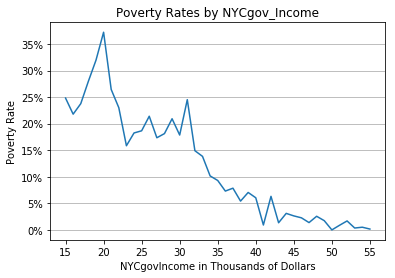

In [7]:
thousands = pu_cats_2016[['NYCgov_Income', 'NYCgov_Pov_Stat', 'WGTP', 'Povunit_Rel', 'Year']].copy()
thousands['NYCgov_Income'] = thousands.NYCgov_Income // 1000
ax = df_for_pov_chart(thousands, 'NYCgov_Income', 'WGTP').loc[15:55].fillna(0).plot(legend=None)
ax.set_yticklabels(['{:.0f}%'.format(x) for x in ax.get_yticks()])
ax.set_title('Poverty Rates by NYCgov_Income')
ax.set_xlabel('NYCgovIncome in Thousands of Dollars')
ax.set_ylabel('Poverty Rate')
ax.grid(which='major', axis='y')

***
## A first look at correlations with NYCgov_Income

So, which of the variables above have the most impact on NYCgov_Income? Below is a list of all the correlations:
* PreTaxIncomePU (which is poverty unit income before taxes) has the strongest correlation with NYCgov_Income, as you would expect.
* NYCgov_IncomeTax and NYCgov_FICAtax are dependent variables, so we'll ignore them.
* The next highest correlations are with NYCgov_MOOP (total poverty unit medical spending), NYCgov_Commuting (poverty unit commuting costs), NYCgov_Childcare (poverty unit childcare costs), and NYCgov_HEAP (poverty unit heating assistance - negative correlation with NYCgov_Income).
***

In [8]:
pov_calc_vars = ['NYCgov_Income', 'PreTaxIncome_PU', 'NYCgov_IncomeTax', 'NYCgov_FICAtax', 'NYCgov_SNAP', 'NYCgov_WIC', 'NYCgov_SchoolBreakfast', 'NYCgov_SchoolLunch', 'NYCgov_HEAP', 'NYCgov_Housing', 'NYCgov_Commuting', 'NYCgov_Childcare', 'NYCgov_MOOP', 'WGTP']

temp = pu_2016.copy()
temp = temp[pov_calc_vars]

calc = pd.DataFrame(DescrStatsW(temp, temp.WGTP).corrcoef, index=temp.columns, columns=temp.columns).NYCgov_Income

print('Weighted Correlations with NYCgov_Income:')
print(calc.reindex(calc.abs().sort_values(ascending=False).index).tail(-1))

Weighted Correlations with NYCgov_Income:
PreTaxIncome_PU           0.982644
NYCgov_IncomeTax          0.930597
NYCgov_FICAtax            0.917120
NYCgov_MOOP               0.439180
NYCgov_Commuting          0.279513
NYCgov_Childcare          0.179909
NYCgov_HEAP              -0.172440
NYCgov_SNAP              -0.083106
NYCgov_SchoolLunch       -0.054682
NYCgov_SchoolBreakfast   -0.046473
NYCgov_WIC               -0.038135
NYCgov_Housing           -0.017215
WGTP                     -0.012472
Name: NYCgov_Income, dtype: float64


## A broader look at NYCgov_Income

We have lots of other poverty-unit variables that we didn't consider above. Let's look at how all of the key poverty-unit 'input' variables correlate with NYCgov_Income, ignoring things like taxes and poverty thresholds.

The top-ten list is below, sorted by absolute value of correlation in descending order:
* Again PreTaxIncome_PU tops the list.
* TotalWorkHrs_PU (total work hours for the poverty unit) has a strong negative correlation with income (it's coded in the dataset as higher hours worked first, thus the negative correlation).
* NYCgov_MOOP, NYCgov_MedPremiums, and NYCgov_MedSpending are all medical expenses - the first one is the total, so we'll focus on that one.
* FamType_PU is family type (single parent, family, couple/no kids, etc.).
* MRGP_adj is mortgage payment.
* HHT is household type (similar to FamType_PU).
* HousingStatus is whether they own or rent, if their rent is subsidized, etc.
* Again NYCgov_Commuting is commuting costs.

***

In [9]:
temp = pu_2016.copy()

# Filter out some variables so we can focus on variables of interest
vars_of_interest = [var for var in pu_vars if not var in ['Off_Pov_Stat', 'Off_Threshold', 'NYCgov_FICAtax', 'NYCgov_IncomeTax', 'NYCgov_PovGap', 'NYCgov_PovGapIndex', 'NYCgov_Pov_Stat', 'NYCgov_Threshold']]
temp = temp[vars_of_interest]

calc = pd.DataFrame(DescrStatsW(temp, temp.WGTP).corrcoef, index=temp.columns, columns=temp.columns).NYCgov_Income
print('Weighted Correlations with NYCgov_Income:')
print(calc.reindex(calc.abs().sort_values(ascending=False).index).tail(-1).head(10))

Weighted Correlations with NYCgov_Income:
PreTaxIncome_PU       0.982644
TotalWorkHrs_PU      -0.451505
NYCgov_MOOP           0.439180
NYCgov_MedPremiums    0.358536
NYCgov_MedSpending    0.353822
FamType_PU           -0.352126
MRGP_adj              0.295846
HHT                  -0.295571
HousingStatus         0.285180
NYCgov_Commuting      0.279513
Name: NYCgov_Income, dtype: float64


***
### Age and Poverty Status in 2016

To give a baseline for what we'll be looking at here, let's take a look at the overall distribution of the NYCgov_Income
(again, this is poverty unit data, the key variable in the poverty calculation).  

We see below that the mean NYCgov_Income is about \\$56,900.  About 70\% of NYCgov_Income values fall between \\$0 and \\$118,000 (marked with a vertical black line below).
***

Description of NYCgov_Income:
Weighted mean: $56,898.20
Weighted std: $61,450.73


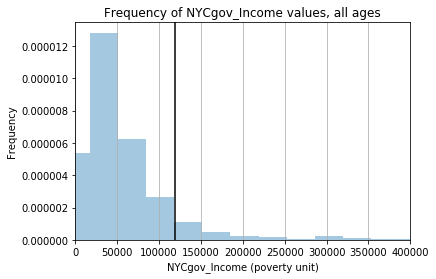

In [10]:
temp = pu_2016
title = 'Frequency of NYCgov_Income values, all ages' 
ax = sns.distplot(temp.NYCgov_Income, hist_kws={'weights': temp.WGTP, 'density': 1}, kde=False) 
ax.grid(which='major', axis='x')
ax.set_xlim(0,400000)
ax.set_xlabel('NYCgov_Income (poverty unit)')
ax.set_ylabel('Frequency')
ax.set_title(title)
plt.axvline(x=118348.93, color='k')
print('Description of NYCgov_Income:')
print('Weighted mean: ' + '${:8,.2f}'.format(DescrStatsW(temp.NYCgov_Income, weights=temp.WGTP).mean))
print('Weighted std: ' + '${:8,.2f}'.format(DescrStatsW(temp.NYCgov_Income, weights=temp.WGTP).std))

***
### Age and Poverty Status in 2016: Young people

Now let's take a step back and look at poverty status by poverty units *headed by* someone of a given age. In particular, 18-year-olds that live with their parents much like they did when they were 14, sharing expenses, are not included here. 

As a result, poverty rates are pretty exorbitant for younger ages - it's not until age 25 that poverty rates begin to stabilize around the 20% rate seen in the general population.
***

Correlation for 18-29 years old: -0.913
Linear regression for 18-29 years old: -6.40 * x + 192.87
Correlation for 30+ years old: 0.780
Linear regression for 30+ years old: 0.19 * x + 10.18


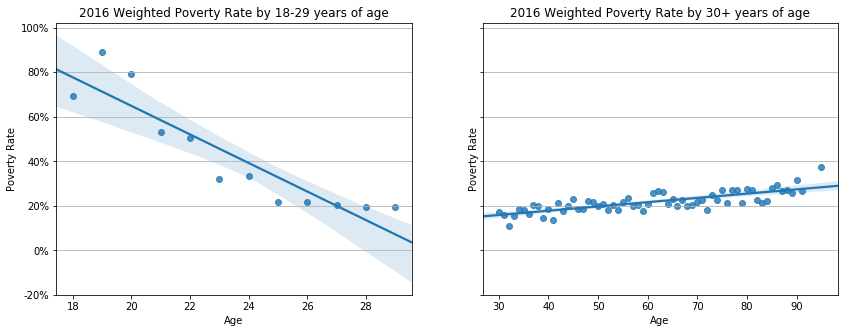

In [11]:
# Set up variables
n = 0
column = raw_inp_vars[n]
year = 2016
pcts = df_for_pov_chart_nocats(pu_2016, raw_inp_vars[n], 'WGTP')
pcts_18_29 = pcts[3:15]
pcts_30plus = pcts[15:]
pcts_18_29.reset_index(inplace=True)
pcts_30plus.reset_index(inplace=True)
m_young, b_young = np.polyfit(pcts_18_29.AGEP, pcts_18_29.Pov, 1)
m_old, b_old = np.polyfit(pcts_30plus.AGEP, pcts_30plus.Pov, 1)


# Chart
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,5), sharey=True)
for year in range(2):
    # initialize variables
    pcts = [pcts_18_29, pcts_30plus][year] 
    group = ['18-29 years', '30+ years']
    m, b = [(m_young, b_young), (m_old, b_old)][year]
    
    # Create regressions
    m, b = np.polyfit(pcts.AGEP, pcts.Pov, 1)
    
    ax = sns.regplot(data=pcts, x=column, y='Pov', ax=axes[year], color=sns.color_palette()[0])#, ci=None)
    ax.set_xlabel('Age')
    ax.set_title('2016 Weighted Poverty Rate by ' + group[year] + ' of age')
    print('Correlation for ' + str(group[year]) + ' old: ' + '{:4.3f}'.format(pcts.corr().iloc[0,1]))
    ax.grid(which='major', axis='y')
    ax.set_ylabel('Poverty Rate')
    ax.set_yticklabels(['{:.0f}%'.format(x) for x in ax.get_yticks()])
    print('Linear regression for ' + str(group[year]) + ' old: ' + '{:4.2f}'.format(m) + ' * x + ' + '{:4.2f}'.format(b))

***
You can see in the plots below that NYCgov_Income varies dramatically at early ages for the heads of poverty units (plotted at ages 19, 22, and 25, and at age 40 for comparison to an older group).  
***

Mean of NYCgov_Income at age 19 : $6,597.41
Mean of NYCgov_Income at age 22 : $20,003.12
Mean of NYCgov_Income at age 25 : $37,262.59
Mean of NYCgov_Income at age 40 : $70,252.57


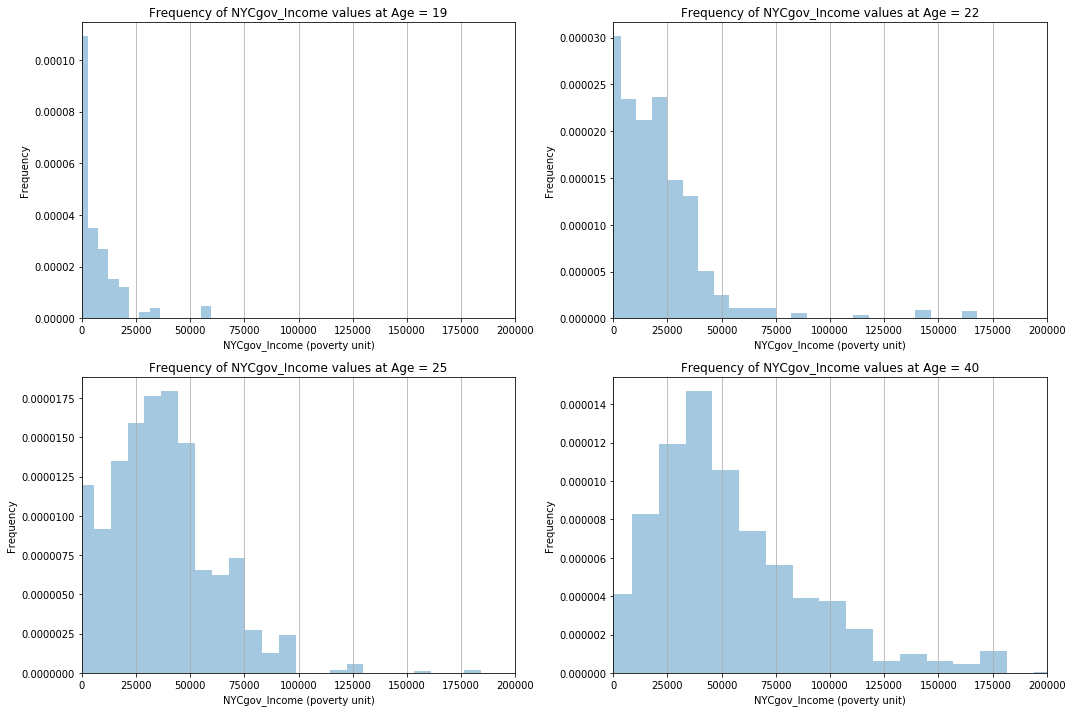

In [12]:
groups = [19, 22, 25, 40]
nrows = 2
ncols = len(groups)//2

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15,10), sharex=True, sharey=True)

for age, axis in zip(groups, range(len(groups))):
    temp = pu_2016[pu_2016.AGEP == age]
    temp_mean = DescrStatsW(temp.NYCgov_Income, weights=temp.WGTP).mean
    print('Mean of NYCgov_Income at age ' + str(age) + ' : ' + '${:6,.2f}'.format(temp_mean))
    title = 'Frequency of NYCgov_Income values at Age = ' + str(age)
    plt.subplot(nrows, ncols, axis+1)
    ax = sns.distplot(temp.NYCgov_Income, hist_kws={'weights': temp.WGTP, 'density': 1}, kde=False) 
    ax.grid(which='major', axis='x')
    ax.set_xlim(0,200000)
    ax.set_xlabel('NYCgov_Income (poverty unit)')
    ax.set_ylabel('Frequency')
    ax.set_title(title)
plt.tight_layout()

***
So the charts above are pretty convincing, but what do the statistics say?  Below we run t-tests for equality of means.

In each, our sample is poverty units headed by a person of age x.  Our statistic is mean NYCgov_Income for the poverty unit.

In nearly all cases, the p-value is zero to three significant digits, indicating strong likelihood of different means even when we're comparing two samples of people only one year apart (e.g. 19 years of age versus 18 years of age).  There are a few exceptions, but the overall point stands: there is a significant difference in mean income between poverty units headed by people of different ages.

Surprisingly, I re-ran the tests for ages 38-41 and ages 48-51, expecting to not see a significant difference; however, in both of these age ranges, the differences were also significant.  This cautions us to not read too much into the results, as a chart of NYCgov_Income by ages 38-41 don't look very different; however, the overall point still stands. 
***

In [13]:
ages = list(range(18,31))

for age1 in ages:
    one = pu_2016[pu_2016.AGEP == age1]
    two = pu_2016[pu_2016.AGEP == age1 - 1]
    comp = CompareMeans.from_data(one.NYCgov_Income, two.NYCgov_Income, weights1=one.WGTP, weights2=two.WGTP)
    print('Comparing age ' + str(age1) + ' to age ' + str(age1-1) + ': ' + str(comp.summary()))

Comparing age 18 to age 17:                           Test for equality of means                          
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
subset #1   6289.2078    981.400      6.408      0.000    4364.655    8213.760
Comparing age 19 to age 18:                           Test for equality of means                          
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
subset #1  -1.115e+04    404.392    -27.571      0.000   -1.19e+04   -1.04e+04
Comparing age 20 to age 19:                           Test for equality of means                          
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
subset #1   6083.4721    217.589     27.959    

***
Ok, so poverty units with younger heads have lower incomes, and that would be consistent with higher poverty rates.  But what about the poverty thresholds?  Even though we're considering them as fixed, maybe the poverty thresholds are higher for poverty units with younger heads?  

First, let's look at the whole group. The minimum poverty threshold is \\$15,017.13, the weighted mean is \\$23,300, and roughly 70\% of poverty units have poverty thresholds below \\$33,033. 
***

Description of NYCgov_Threshold:
Weighted mean: $23,305.12
Weighted std: $9,728.32


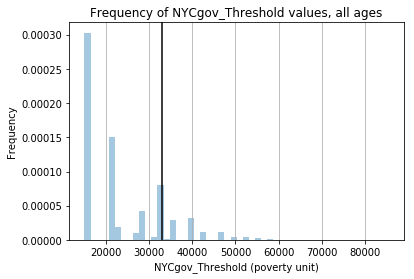

In [14]:
temp = pu_2016
title = 'Frequency of NYCgov_Threshold values, all ages' 
ax = sns.distplot(temp.NYCgov_Threshold, hist_kws={'weights': temp.WGTP, 'density': 1}, kde=False) 
ax.grid(which='major', axis='x')
ax.set_xlabel('NYCgov_Threshold (poverty unit)')
ax.set_ylabel('Frequency')
plt.axvline(x=33033.44, color='k')
ax.set_title(title)

print('Description of NYCgov_Threshold:')
print('Weighted mean: ' + '${:8,.2f}'.format(DescrStatsW(temp.NYCgov_Threshold, weights=temp.WGTP).mean))
print('Weighted std: ' + '${:8,.2f}'.format(DescrStatsW(temp.NYCgov_Threshold, weights=temp.WGTP).std))

***
As you can see in the charts below, poverty thresholds actually tend to increase with increase age of the head of the
poverty unit in these younger poverty units.
***

Mean of NYCgov_Threshold at age 19 : $15,919.24
Mean of NYCgov_Threshold at age 22 : $17,051.13
Mean of NYCgov_Threshold at age 25 : $19,102.38
Mean of NYCgov_Threshold at age 40 : $26,764.70


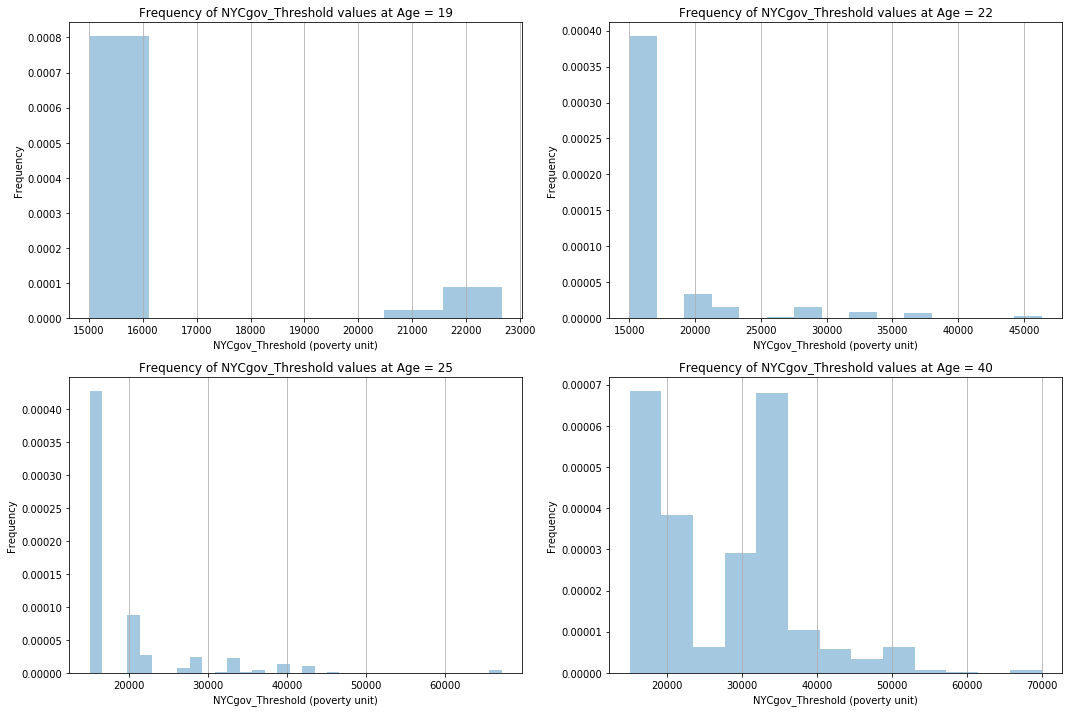

In [15]:
groups = [19, 22, 25, 40]
nrows = 2
ncols = len(groups)//2

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15,10), sharex=True, sharey=True)

for age, axis in zip(groups, range(len(groups))):
    temp = pu_2016[pu_2016.AGEP == age]
    temp_mean = DescrStatsW(temp.NYCgov_Threshold, weights=temp.WGTP).mean
    print('Mean of NYCgov_Threshold at age ' + str(age) + ' : ' + '${:6,.2f}'.format(temp_mean))
    title = 'Frequency of NYCgov_Threshold values at Age = ' + str(age)
    plt.subplot(nrows, ncols, axis+1)
    ax = sns.distplot(temp.NYCgov_Threshold, hist_kws={'weights': temp.WGTP, 'density': 1}, kde=False) 
    ax.grid(which='major', axis='x')
    #ax.set_xlim(0,200000)
    ax.set_xlabel('NYCgov_Threshold (poverty unit)')
    ax.set_ylabel('Frequency')
    ax.set_title(title)
plt.tight_layout()

***
Again, the means tests confirm our visuals, as each p-value is zero to 3 significant digits.  The poverty thresholds are
not the same across age groupings. For poverty units with younger heads, the poverty unit income (NYCgov_Income) is the
key correlator with poverty.
***

In [16]:
ages = list(range(18,31))

for age1 in ages:
    one = pu_2016[pu_2016.AGEP == age1]
    two = pu_2016[pu_2016.AGEP == age1 - 1]
    comp = CompareMeans.from_data(one.NYCgov_Threshold, two.NYCgov_Threshold, weights1=one.WGTP, weights2=two.WGTP)
    print('Comparing age ' + str(age1) + ' to age ' + str(age1-1) + ': ' + str(comp.summary()))

Comparing age 18 to age 17:                           Test for equality of means                          
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
subset #1   2126.1496    402.820      5.278      0.000    1336.208    2916.092
Comparing age 19 to age 18:                           Test for equality of means                          
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
subset #1  -3759.7186    138.371    -27.171      0.000   -4030.963   -3488.474
Comparing age 20 to age 19:                           Test for equality of means                          
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
subset #1    743.8148     55.828     13.323    

***
Is it that younger-headed poverty units make less money per hour, or do they work less? The charts below demonstrate that work hours for poverty units with younger heads are limited.
***

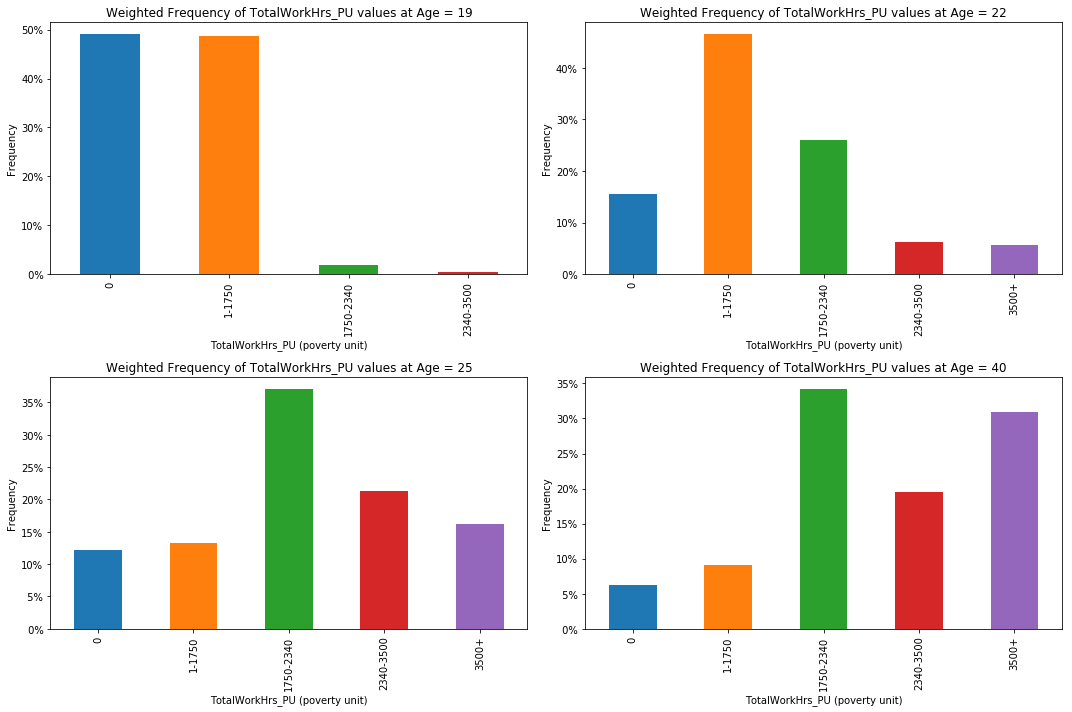

In [17]:
groups = [19, 22, 25, 40]
nrows = 2
ncols = len(groups)//2

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15,10), sharex=True, sharey=True)

for age, axis in zip(groups, range(len(groups))):
    temp = pu_2016[pu_2016.AGEP == age].replace({'TotalWorkHrs_PU': {1:'3500+', 2:'2340-3500', 3:'1750-2340', 4:'1-1750', 5:'0'}})
    title = 'Weighted Frequency of TotalWorkHrs_PU values at Age = ' + str(age)
    plt.subplot(nrows, ncols, axis+1)
    counts = temp.groupby('TotalWorkHrs_PU').sum().WGTP
    pcts = 100*counts/counts.sum()
    ax = pcts.plot(kind='bar')
    ax.set_xlabel('TotalWorkHrs_PU (poverty unit)')
    ax.set_ylabel('Frequency')
    ax.set_title(title)
    ax.set_yticklabels(['{:2.0f}%'.format(x) for x in ax.get_yticks()])
plt.tight_layout()

***
Switching to individuals rather than poverty units, we see that work hours by individual fluctuate strongly with age. In particular, around age 20 and above age 60, work hours are greatly reduced.
***

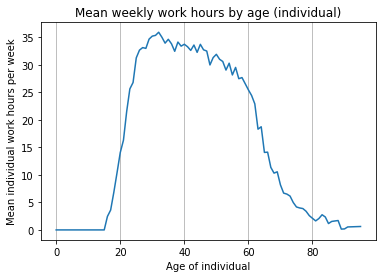

In [18]:
ages = all_2016.AGEP.unique()
ages.sort()
means = pd.Series(index=ages)

for age in ages:
    counts = df_for_stat_chart(all_2016.loc[all_2016.AGEP == age], 'WKHP', 'PWGTP')
    counts['Weighted'] = counts.index * counts.PWGTP
    means[age] = counts.sum().Weighted
    
ax = means.plot()
ax.set_title('Mean weekly work hours by age (individual)')
ax.set_ylabel('Mean individual work hours per week')
ax.set_xlabel('Age of individual')
ax.grid(which='major', axis='x')

***
As before, the mean work hours of individuals by age at the younger end of the spectrum are significantly different, with p-values generally at zero to three significant digits.
***

In [19]:
ages = list(range(18,31))

for age1 in ages:
    one = all_2016[all_2016.AGEP == age1]
    two = all_2016[all_2016.AGEP == age1 - 1]
    comp = CompareMeans.from_data(one.WKHP, two.WKHP, weights1=one.PWGTP, weights2=two.PWGTP)
    print('Comparing age ' + str(age1) + ' to age ' + str(age1-1) + ': ' + str(comp.summary()))

Comparing age 18 to age 17:                           Test for equality of means                          
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
subset #1      3.2405      0.052     61.961      0.000       3.138       3.343
Comparing age 19 to age 18:                           Test for equality of means                          
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
subset #1      3.5524      0.068     52.136      0.000       3.419       3.686
Comparing age 20 to age 19:                           Test for equality of means                          
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
subset #1      3.6471      0.073     49.959    

***
One of the reasons that younger workers' work hours are reduced is that they're still getting their education.  As shown below, 52% of 19-year-olds have some college; by age 25, 70% have some college, a bachelor's degree, or more.
***

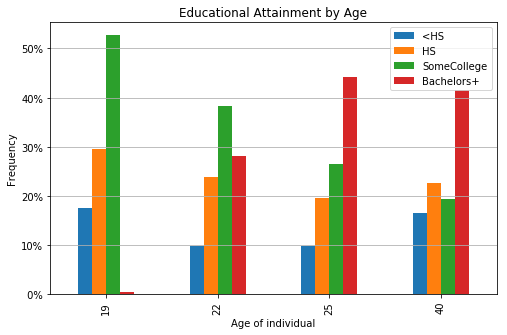

In [20]:
# Create slices of EducAttain by age
agg = pd.DataFrame()
for x in [19, 22, 25, 40]:
    tester = df_for_stat_chart(cats_2016.loc[(cats_2016.AGEP == x) & (cats_2016.EducAttain != 'NA')], 'EducAttain', 'PWGTP')
    agg[x] = tester.PWGTP
agg.index.name = 'Educational Attainment'

#chart
ax = agg.iloc[[0,2,3,1],:].T.plot(kind='bar', figsize=(8,5))
ax.legend(loc='best')
ax.set_title('Educational Attainment by Age')
ax.set_xlabel('Age of individual')
ax.set_ylabel('Frequency')
ax.set_yticklabels(['{:2.0f}%'.format(100*x) for x in ax.get_yticks()])
ax.grid(which='major', axis='y')

***
What about employment status among young people?  While only 3.5% of 40-year-olds are unemployed, nearly 12% of 22-year-olds are. Note that the 60% of 19-year-olds that are not in the labor force is relatively close to the 52% of 19-year-olds with 'some college'. The not-in-the-labor-force group diminishes to 21% by age 25. We'll examine not-in-the-labor-force in more detail later.
***

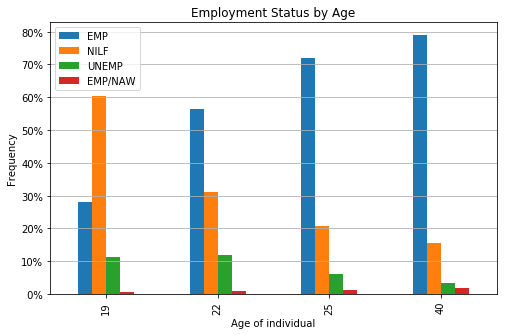

In [21]:
# Create slices of EducAttain by age
agg = pd.DataFrame()
for x in [19, 22, 25, 40]:
    tester = df_for_stat_chart(cats_2016.loc[(cats_2016.AGEP == x) & (cats_2016.EducAttain != 'NA')], 'ESR', 'PWGTP')
    agg[x] = tester.PWGTP
agg.index.name = 'Employment Status'

#chart
ax = agg.iloc[[0,2,3,1],:].T.plot(kind='bar', figsize=(8,5))
ax.legend(loc='best')
ax.set_title('Employment Status by Age')
ax.set_xlabel('Age of individual')
ax.set_ylabel('Frequency')
ax.set_yticklabels(['{:2.0f}%'.format(100*x) for x in ax.get_yticks()])
ax.grid(which='major', axis='y')

***
### Age and Poverty Status in 2016: Older people

What about older poverty units? The chart below looks essentially linear, with a notable outlier at 95 years of age.  

But the issue is that even if the chart is linear, the poverty rates keep going up. In particular, among poverty units 
headed by someone between the ages of 30 and 60, none of them have poverty rates above 25%. But over *half* of the cohorts of poverty units headed by someone aged 60-95 have poverty rates over 25%.  Why?
***

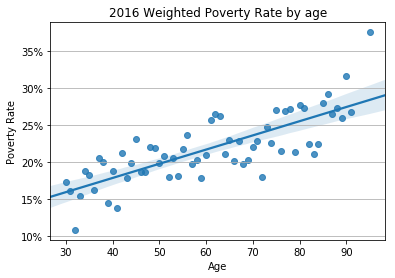

In [22]:
# Set up variables
pcts = df_for_pov_chart_nocats(all_2016.loc[all_2016.AGEP >= 30], 'AGEP', 'WGTP')
pcts.reset_index(inplace=True)

# Chart
ax = sns.regplot(data=pcts, x=column, y='Pov')
ax.set_title('2016 Weighted Poverty Rate by age')
ax.set_xlabel('Age')
ax.set_ylabel('Poverty Rate')
ax.set_yticklabels(['{:.0f}%'.format(x) for x in ax.get_yticks()])
ax.grid(which='major', axis='y')

***
We saw above that limited work hours for younger poverty units were strongly correlated with high poverty rates. What about work hours for poverty units headed by older people? 

And how do we define 'older people' for this analysis?  Given the poverty-rate chart above, where just after age 60,
three age cohorts are well above the regression line and above a 25% poverty rate, let's look at ages 60 and above. This will also cover the transition from work to retirement for many (common retirement ages and federal-benefits ages being 62, 65, and 70).

We see below that work hours at age 60 look reasonably close (though lower) to work hours at age 40.  Not surprisingly, by age 70 most poverty units have no work hours.
***

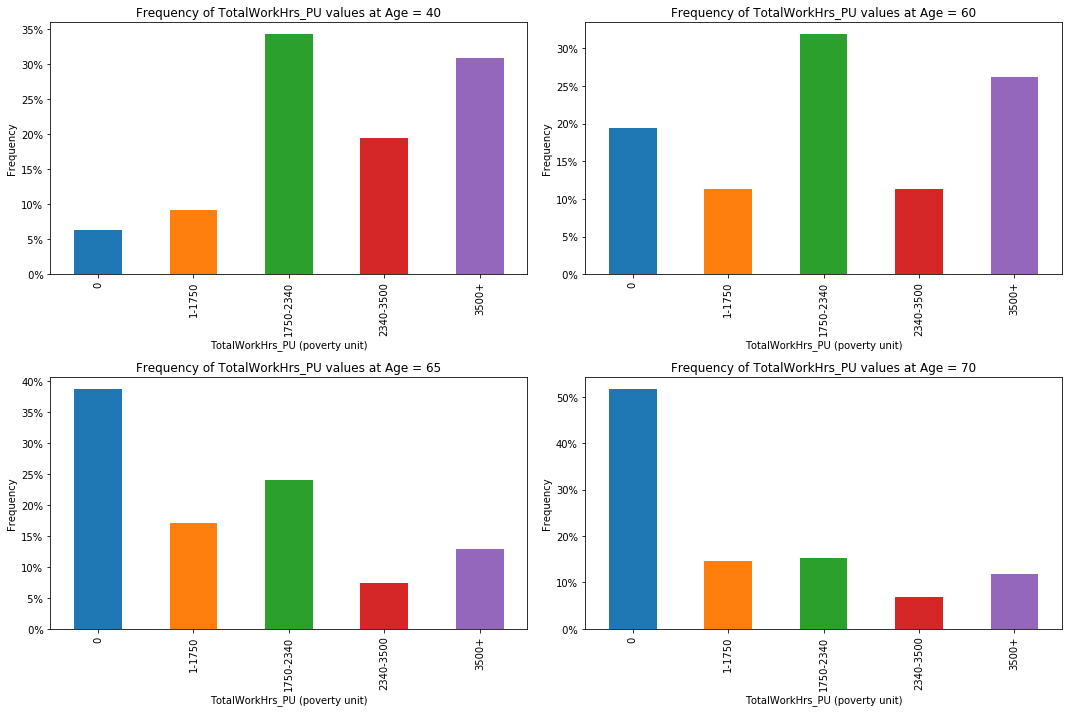

In [23]:
groups = [40, 60, 65, 70]
nrows = 2
ncols = len(groups)//2

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15,10), sharex=True, sharey=True)

for age, axis in zip(groups, range(len(groups))):
    temp = pu_2016[pu_2016.AGEP == age].replace({'TotalWorkHrs_PU': {1:'3500+', 2:'2340-3500', 3:'1750-2340', 4:'1-1750', 5:'0'}})
    title = 'Frequency of TotalWorkHrs_PU values at Age = ' + str(age)
    plt.subplot(nrows, ncols, axis+1)
    counts = temp.groupby('TotalWorkHrs_PU').sum().WGTP
    pcts = 100*counts/counts.sum()
    ax = pcts.plot(kind='bar')
    ax.set_xlabel('TotalWorkHrs_PU (poverty unit)')
    ax.set_ylabel('Frequency')
    ax.set_yticklabels(['{:2.0f}%'.format(x) for x in ax.get_yticks()])
    ax.set_title(title)
plt.tight_layout()

***
The charts below show NYCgov_Income for poverty units headed by someone aged 40 (for comparison), 60, 65, and 70, along
with their means.  Essentially, while the mean at age 40 is about \\$70,000, after age 57 the mean decreases below 
\\$65,000 and trends generally down from there.

Interestingly, the mean income at age 70 appears to be slightly higher than at age 65, although it's 
still below the mean at age 40. We'll dig into that a few points below.
***

Mean of NYCgov_Income at age 40 : $70,252.57
Mean of NYCgov_Income at age 60 : $57,991.97
Mean of NYCgov_Income at age 65 : $53,767.55
Mean of NYCgov_Income at age 70 : $61,243.96


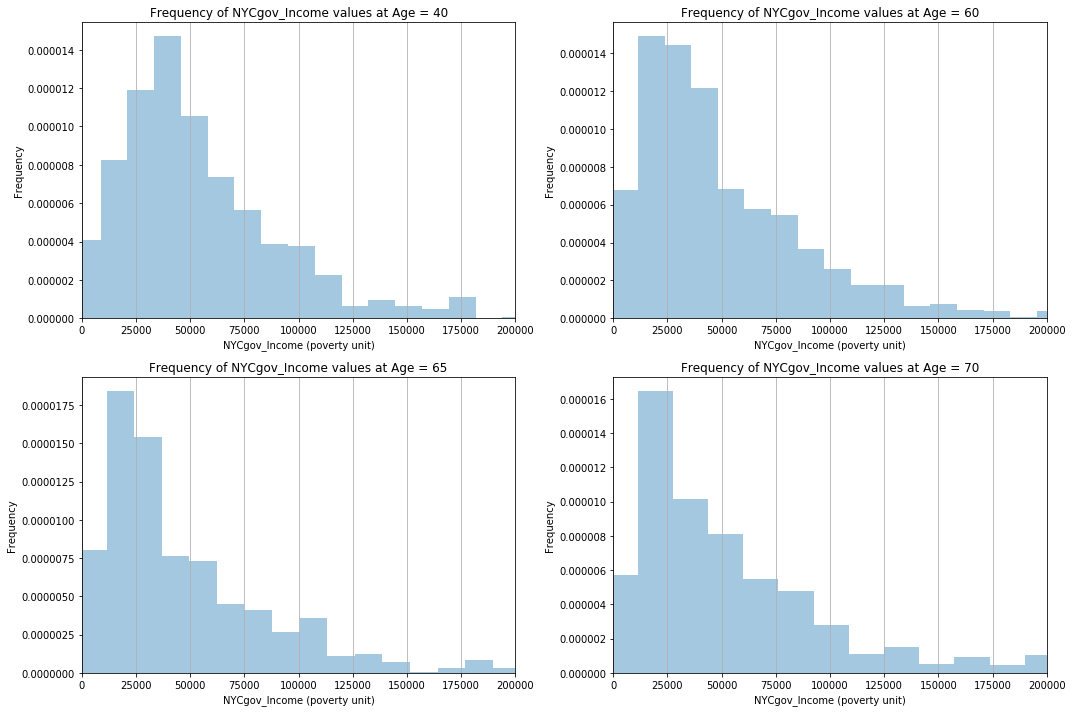

In [24]:
groups = [40, 60, 65, 70]
nrows = 2
ncols = len(groups)//2

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15,10), sharex=True, sharey=True)

for age, axis in zip(groups, range(len(groups))):
    temp = pu_2016[pu_2016.AGEP == age]
    temp_mean = DescrStatsW(temp.NYCgov_Income, weights=temp.WGTP).mean
    print('Mean of NYCgov_Income at age ' + str(age) + ' : ' + '${:6,.2f}'.format(temp_mean))
    title = 'Frequency of NYCgov_Income values at Age = ' + str(age)
    plt.subplot(nrows, ncols, axis+1)
    ax = sns.distplot(temp.NYCgov_Income, hist_kws={'weights': temp.WGTP, 'density': 1}, kde=False)
    ax.grid(which='major', axis='x')
    ax.set_xlim(0,200000)
    ax.set_xlabel('NYCgov_Income (poverty unit)')
    ax.set_ylabel('Frequency')
    ax.set_title(title)
plt.tight_layout()

***
Here's another quick-and-dirty look at the mean NYCgov_Income by age of the head of the poverty unit. We see what appear to be slight increases from age 65 to 70, and a defined spike at age 70, followed by pretty precipitous declines. 
***

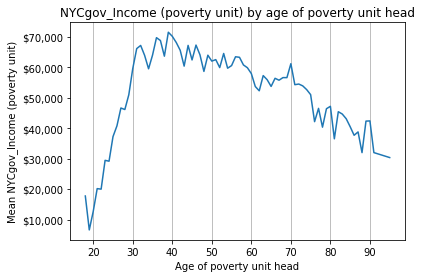

In [25]:
temp = pu_2016.loc[(pu_2016.AGEP >= 18)].copy()
temp['Povunit_Rel'] = 'Head'
ages = all_2016.AGEP.unique()
ages.sort()
ages = ages[18:]
means = pd.Series(index=ages)

for age in ages:
    counts = df_for_stat_chart(temp.loc[temp.AGEP == age], 'NYCgov_Income', 'WGTP')
    counts['Weighted'] = counts.index * counts.WGTP
    means[age] = counts.sum().Weighted
    
ax = means.plot()
ax.set_title('NYCgov_Income (poverty unit) by age of poverty unit head')
ax.set_ylabel('Mean NYCgov_Income (poverty unit)')
ax.set_xlabel('Age of poverty unit head')
ax.set_yticklabels(['${:5,.0f}'.format(x) for x in ax.get_yticks()])
ax.grid(which='major', axis='x')

***
We see that individual wages fall by roughly \\$24,000 on average between ages 60 and 70, and keep falling from there.
***

Mean salary/wages at age 60: 41,468
Mean salary/wages at age 70: 17,087


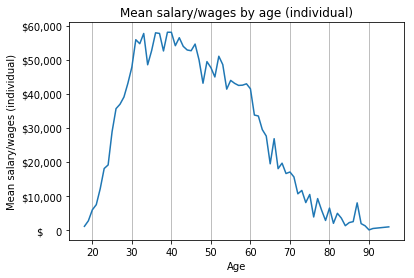

In [26]:
temp = all_2016.loc[(all_2016.AGEP >= 18)].copy()
ages = all_2016.AGEP.unique()
ages.sort()
ages = ages[18:]
means = pd.Series(index=ages)

for age in ages:
    counts = df_for_stat_chart(temp.loc[temp.AGEP == age], 'WAGP_adj', 'PWGTP')
    counts['Weighted'] = counts.index * counts.PWGTP
    means[age] = counts.sum().Weighted

age_60 = all_2016.loc[all_2016.AGEP == 60]
mean_60 = DescrStatsW(age_60.WAGP_adj, age_60.PWGTP).mean
print('Mean salary/wages at age 60: ' + '{:5,.0f}'.format(mean_60))

age_70 = all_2016.loc[all_2016.AGEP == 70]
mean_70 = DescrStatsW(age_70.WAGP_adj, age_70.PWGTP).mean
print('Mean salary/wages at age 70: ' + '{:5,.0f}'.format(mean_70))

ax = means.plot()
ax.set_title('Mean salary/wages by age (individual)')
ax.set_ylabel('Mean salary/wages (individual)')
ax.set_xlabel('Age')
ax.set_yticklabels(['${:5,.0f}'.format(x) for x in ax.get_yticks()])
ax.grid(which='major', axis='x')

***
Social security and retirement funds make up some (but not all) of the shortfall. As seen below, Social Security payments increase by about \\$10,000 on average between age 60 and 70 (again, these are individual payments).
***

Mean Social Security payments at age 60: 1,021
Mean Social Security payments at age 70: 11,237


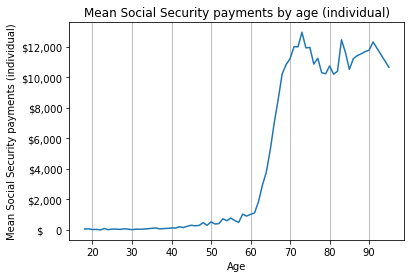

In [27]:
temp = all_2016.loc[(all_2016.AGEP >= 18)].copy()
ages = all_2016.AGEP.unique()
ages.sort()
ages = ages[18:]
means = pd.Series(index=ages)

for age in ages:
    counts = df_for_stat_chart(temp.loc[temp.AGEP == age], 'SSP_adj', 'PWGTP')
    counts['Weighted'] = counts.index * counts.PWGTP
    means[age] = counts.sum().Weighted

age_60 = all_2016.loc[all_2016.AGEP == 60]
mean_60 = DescrStatsW(age_60.SSP_adj, age_60.PWGTP).mean
print('Mean Social Security payments at age 60: ' + '{:5,.0f}'.format(mean_60))

age_70 = all_2016.loc[all_2016.AGEP == 70]
mean_70 = DescrStatsW(age_70.SSP_adj, age_70.PWGTP).mean
print('Mean Social Security payments at age 70: ' + '{:5,.0f}'.format(mean_70))

ax = means.plot()
ax.set_title('Mean Social Security payments by age (individual)')
ax.set_ylabel('Mean Social Security payments (individual)')
ax.set_xlabel('Age')
ax.set_yticklabels(['${:5,.0f}'.format(x) for x in ax.get_yticks()])
ax.grid(which='major', axis='x')

***
Mean individual retirement payments increase an average of nearly \\$5,000 between ages 60 and 70, but again these
cumulative payments generally only offset some of the declines in wages/salary. 
***

Mean retirement payments at age 60: 2,405
Mean retirement payments at age 70: 7,101


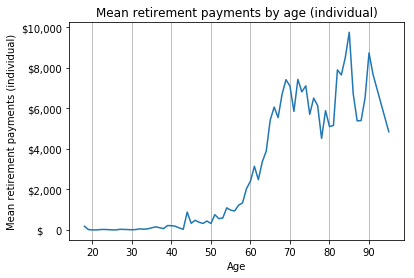

In [28]:
temp = all_2016.loc[(all_2016.AGEP >= 18)].copy()
ages = all_2016.AGEP.unique()
ages.sort()
ages = ages[18:]
means = pd.Series(index=ages)

for age in ages:
    counts = df_for_stat_chart(temp.loc[temp.AGEP == age], 'RETP_adj', 'PWGTP')
    counts['Weighted'] = counts.index * counts.PWGTP
    means[age] = counts.sum().Weighted

age_60 = all_2016.loc[all_2016.AGEP == 60]
mean_60 = DescrStatsW(age_60.RETP_adj, age_60.PWGTP).mean
print('Mean retirement payments at age 60: ' + '{:5,.0f}'.format(mean_60))

age_70 = all_2016.loc[all_2016.AGEP == 70]
mean_70 = DescrStatsW(age_70.RETP_adj, age_70.PWGTP).mean
print('Mean retirement payments at age 70: ' + '{:5,.0f}'.format(mean_70))

ax = means.plot()
ax.set_title('Mean retirement payments by age (individual)')
ax.set_ylabel('Mean retirement payments (individual)')
ax.set_xlabel('Age')
ax.set_yticklabels(['${:5,.0f}'.format(x) for x in ax.get_yticks()])
ax.grid(which='major', axis='x')

***
As we'd expect by now, the mean NYCgov_Income in most older age groups is significantly different from other age groups, with a few exceptions.
***

In [29]:
ages = list(range(60,70))

for age1 in ages:
    one = pu_2016[pu_2016.AGEP == age1]
    two = pu_2016[pu_2016.AGEP == age1 - 1]
    comp = CompareMeans.from_data(one.NYCgov_Income, two.NYCgov_Income, weights1=one.WGTP, weights2=two.WGTP)
    print('Comparing age ' + str(age1) + ' to age ' + str(age1-1) + ': ' + str(comp.summary()))

Comparing age 60 to age 59:                           Test for equality of means                          
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
subset #1  -1929.1374    345.469     -5.584      0.000   -2606.251   -1252.024
Comparing age 61 to age 60:                           Test for equality of means                          
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
subset #1  -4257.9865    346.867    -12.276      0.000   -4937.841   -3578.132
Comparing age 62 to age 61:                           Test for equality of means                          
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
subset #1  -1404.3971    402.231     -3.492    

***
Ok, the data supports an intuition that poverty units headed by younger people often don't have the work hours to
generate the income they need to overcome poverty, and that poverty units headed by older people also have less work
hours.

But what about all of the other poverty units?  As the chart below shows, over 60% of the households in poverty are 
actually headed by someone who is between 30 and 60 years of age. 
***

Percent of poverty units in poverty headed by someone aged 30-60: 60.8%


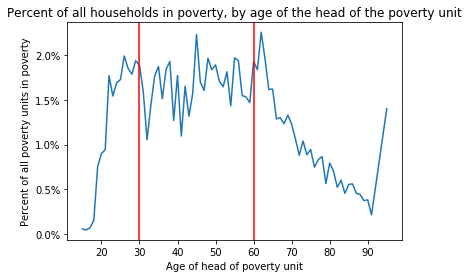

In [30]:
temp = pu_2016.copy()
counts = temp.loc[temp['Povunit_Rel'] == 1, ['NYCgov_Pov_Stat', 'AGEP', 'WGTP']].groupby(['AGEP', 'NYCgov_Pov_Stat']).sum()
counts = counts.unstack('NYCgov_Pov_Stat')
# Sum along columns here to get percent down the column since we're counting relative percent in poverty by age
# These gymnastics are necessary to get the household-weighted percentages by age group
subtotals = counts.sum() 
pcts = 100 * counts / subtotals
pov_30_60 = pcts.iloc[15:46,1].sum()

ax = pcts['WGTP'][1].plot()
ax.set_title('Percent of all households in poverty, by age of the head of the poverty unit')
ax.set_xlabel('Age of head of poverty unit')
ax.set_ylabel('Percent of all poverty units in poverty')
plt.axvline(x=30, color='r')
plt.axvline(x=60, color='r')
ax.set_yticklabels(['{:2.1f}%'.format(x) for x in ax.get_yticks()])

print('Percent of poverty units in poverty headed by someone aged 30-60: ' + '{:3.1f}%'.format(pov_30_60))

***
We see below that education has a powerful correlation with poverty rates, especially after age 25. The mean individual
poverty rate among those without a high school degree is 30%, while it's 22% for high school graduates, 18% for those with
some college, and only 12% among college graduates.
***

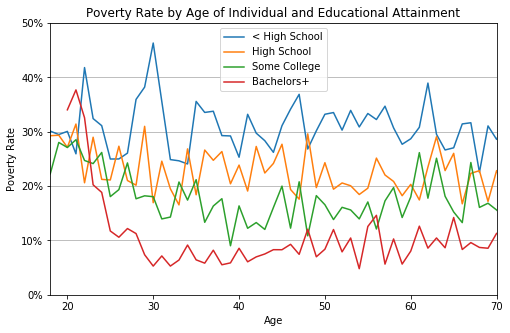

In [31]:
# Get dataframes of poverty rates by educational level
l_hs = df_for_pov_chart(cats_2016.loc[cats_2016.EducAttain == '<HS'], 'AGEP', 'PWGTP')
hs = df_for_pov_chart(cats_2016.loc[cats_2016.EducAttain == 'HS'], 'AGEP', 'PWGTP')
sc = df_for_pov_chart(cats_2016.loc[cats_2016.EducAttain == 'SomeCollege'], 'AGEP', 'PWGTP')
b = df_for_pov_chart(cats_2016.loc[cats_2016.EducAttain == 'Bachelors+'], 'AGEP', 'PWGTP')

# Rename columns and join dataframes
l_hs.rename(columns={'Pov': '< High School'}, inplace=True)
hs.rename(columns={'Pov': 'High School'}, inplace=True)
sc.rename(columns={'Pov': 'Some College'}, inplace=True)
b.rename(columns={'Pov': 'Bachelors+'}, inplace=True)
all = l_hs.join([hs,sc,b], how='outer')

# Chart
ax = all.plot(xlim=[18,70], ylim=[0,50], figsize=(8,5))
ax.legend(loc=9)
ax.set_title('Poverty Rate by Age of Individual and Educational Attainment')
ax.set_ylabel('Poverty Rate')
ax.set_xlabel('Age')
ax.set_yticklabels(['{:.0f}%'.format(x) for x in ax.get_yticks()])
ax.grid(which='major', axis='y')

***
At an individual level, total earnings correlate strongly with education.  Individuals with less than a high school diploma earn on average about \\$7,500 from all sources; those with a diploma, about \\$25,000; some college, about
\\$31,000; and those with at least a bachelor's degree earn over \\$82,000 on average.

It's worth pointing out that this is income from all sources, including from things like investments and rental properties.

It's also worth reinforcing the truism that correlation does not imply causation - in this context, those who are likely
to collect investments and rental properties are also more likely to go to college and get a degree. (In other words,
even in the face of these statistics, some people will still not get a college degree, or even a diploma or GED.)
***

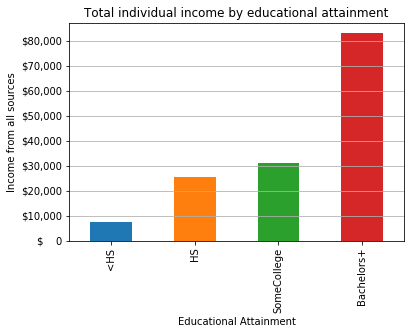

In [32]:
# Create a temp dataframe and populate it with income from all sources, and weighted income
temp = cats_2016.copy()
temp['All_Income'] = temp.WAGP_adj + temp.INTP_adj + temp.SEMP_adj + temp.SSP_adj + temp.SSIP_adj + \
    temp.PA_adj + temp.RETP_adj + temp.OI_adj
temp['Wgtd_All_Income'] = temp.All_Income * temp.PWGTP

levels = ['<HS', 'HS', 'SomeCollege', 'Bachelors+']
means = pd.Series(index=levels)

for level in levels:
    counts = temp.loc[temp.EducAttain == level].Wgtd_All_Income.sum()
    denom = temp.loc[temp.EducAttain == level].PWGTP.sum()
    means[level] = counts/denom

ax = means.plot(kind='bar')
ax.set_title('Total individual income by educational attainment')
ax.set_xlabel('Educational Attainment')
ax.set_ylabel('Income from all sources')
ax.set_yticklabels(['${:5,.0f}'.format(x) for x in ax.get_yticks()])
ax.grid(which='major', axis='y')

***
The chart above looks pretty convincing, but just to keep ourselves honest, let's run a t-test of means. Below we test the null hypothesis that there's no difference between the mean total individual income of high-school graduates and
those with some college.  With a p-value of zero to three digits, we can conclude that there is likely a 
true difference.
***

In [33]:
temp = cats_2016.copy()
temp['All_Income'] = temp.WAGP_adj + temp.INTP_adj + temp.SEMP_adj + temp.SSP_adj + temp.SSIP_adj + \
    temp.PA_adj + temp.RETP_adj + temp.OI_adj

one = temp[temp.EducAttain == 'HS']
two = temp[temp.EducAttain == 'SomeCollege']
comp = CompareMeans.from_data(one.All_Income, two.All_Income, weights1=one.PWGTP, weights2=two.PWGTP)
print('Comparing mean individual income of high school graduates to those with some college: ')
print(str(comp.summary()))

Comparing mean individual income of high school graduates to those with some college: 
                          Test for equality of means                          
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
subset #1  -5932.0293     44.287   -133.945      0.000   -6018.830   -5845.228


***
Since roughly 80% of working-age New Yorkers' total income comes from wages (per weighted means from the 
data), and since it's a simpler metric to work with and understand, let's turn our attention to wages.

Specifically, let's look at mean individual wages by ethnicity.  It's startling. On average, white people in New York 
have wages of nearly \\$50,000, while the averages for other ethnicities don't crack \\$30,000.
***

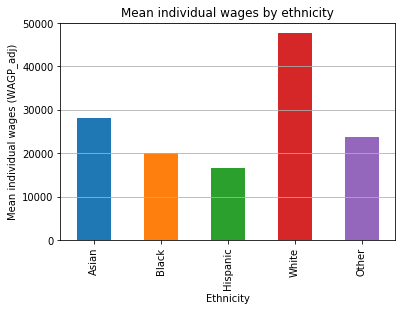

In [34]:
# Create a temp dataframe and populate it with income from all sources, and weighted income
temp = cats_2016.copy()
temp['Wgtd_WAGP'] = temp.WAGP_adj * temp.PWGTP

ethnicities = ['Asian', 'Black', 'Hispanic', 'White', 'Other']
means = pd.Series(index=ethnicities)

for ethnicity in ethnicities:
    counts = temp.loc[temp.Ethnicity == ethnicity].Wgtd_WAGP.sum()
    denom = temp.loc[temp.Ethnicity == ethnicity].PWGTP.sum()
    means[ethnicity] = counts/denom

ax = means.plot(kind='bar')
ax.set_title('Mean individual wages by ethnicity')
ax.set_xlabel('Ethnicity')
ax.set_ylabel('Mean individual wages (WAGP_adj)')
ax.grid(which='major', axis='y')

***
To check our visuals, let's do a t-test of means for Black and Hispanic (the closest two means in the chart above). The p-value is zero to three digits, indicating that we have a high degree of confidence that the true mean is different.
***

In [35]:
temp = cats_2016.copy()

one = temp[temp.Ethnicity == 'Black']
two = temp[temp.Ethnicity == 'Hispanic']
comp = CompareMeans.from_data(one.WAGP_adj, two.WAGP_adj, weights1=one.PWGTP, weights2=two.PWGTP)
print('Comparing mean individual wages for Black versus Hispanic people in NYC:')
print(str(comp.summary()))

Comparing mean individual wages for Black versus Hispanic people in NYC:
                          Test for equality of means                          
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
subset #1   3448.2902     33.644    102.492      0.000    3382.348    3514.232


***
We know that there are lots of 'confounding variables' here - specifically, people's wages vary by tons of factors, including things like education levels, where they work, what they do, etc.

*We don't have enough features in the data to truly understand the variation between wages and ethnicity* - but let's dig in by a number of factors.

Some of the variation in wages can be explained by education level. Over 50% of white adults in NYC have bachelor's degrees, compared to less than 20% of Hispanics.  And nearly 30% of Hispanic adults in NYC have less than a high-school
education, compared to only 8% of white adults.
***

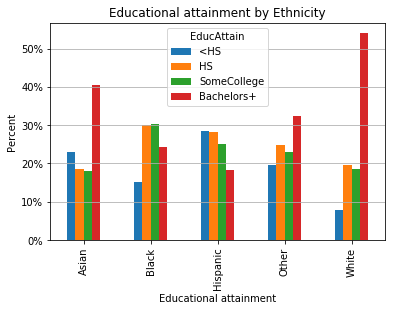

In [36]:
ethnicities = ['Asian', 'Black', 'Hispanic', 'White']
levels = ['<HS', 'HS', 'SomeCollege', 'Bachelors+']

temp = cats_2016.copy()
counts = temp.loc[temp.AGEP >= 18].groupby(['Ethnicity', 'EducAttain']).AGEP.count()
sums = temp.loc[temp.AGEP >= 18].groupby('Ethnicity').AGEP.count()
pcts = 100*counts/sums
pcts = pcts.unstack('EducAttain')
pcts = pcts.iloc[:, [0,2,3,1]]

ax = pcts.plot(kind='bar')
ax.set_xlabel('Educational attainment')
ax.set_ylabel('Percent')
ax.set_title('Educational attainment by Ethnicity')
ax.set_yticklabels(['{:.0f}%'.format(x) for x in ax.get_yticks()])
ax.grid(which='major', axis='y')

***
But education levels don't explain all of the difference in mean wages. Let's look at education levels and ethnicity by the boroughs (regions) of New York.

At high-school education or less, ethnicity matters, but does not seem to have a regular correlation:
* A person with less than a high-school diploma will earn less than \\$10,000 per year on average, across race and borough.
* A high school graduate will tend to earn about \\$20,000 on average, across race and borough.  
* Manhattan and Staten Island appear to have more ethnic inequality at this level.

Ethnicity has the strongest correlation with wages among those with a bachelor's degree or more:
* In the Bronx, a white person with a bachelor's degree averages roughly 50% more in wages than a non-white person.
* The same is true in Manhattan (with the exception of Asians with bachelor's degrees). 
* A particularly striking data point is in Staten Island, where non-black college graduates earn on average 50% more than black college graduates.

Note that most of these groups have sample sizes in the multiple hundreds - the notable exception being Staten Island, where sample sizes range as small as 50.
***

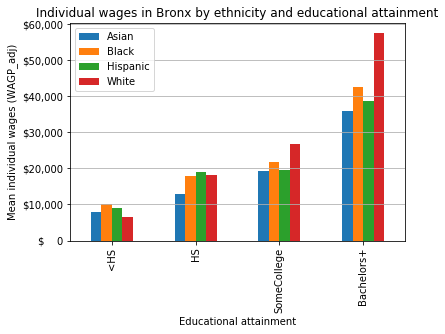

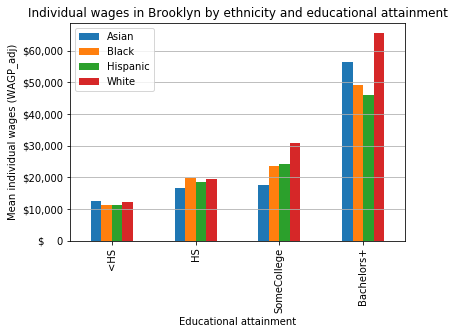

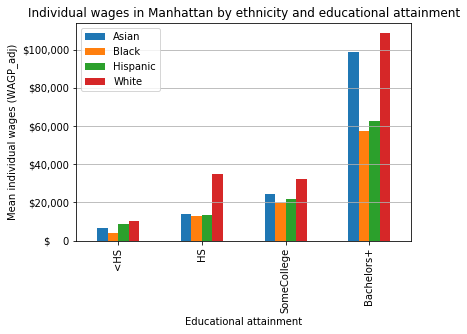

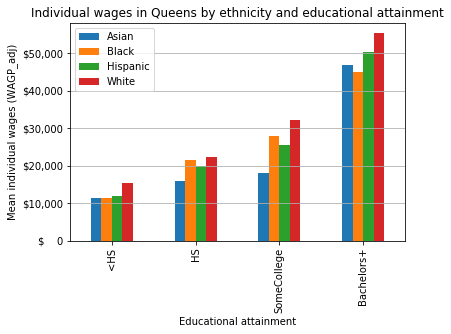

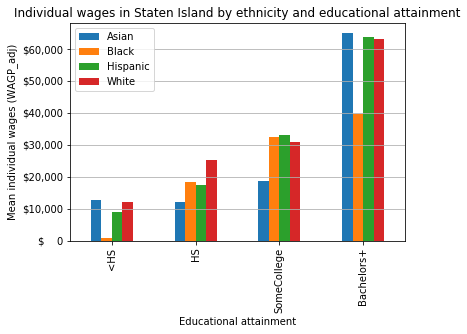

In [37]:
ethnicities = ['Asian', 'Black', 'Hispanic', 'White']
boros = ['Bronx', 'Brooklyn', 'Manhattan', 'Queens', 'Staten Island']
levels = ['<HS', 'HS', 'SomeCollege', 'Bachelors+']

for boro, axis in zip(boros, range(len(boros))):
    
    # Create dataframe of mean weighted WAGP_adj for (boro) with (ethnicities) as columns and (levels) as rows
    means = pd.DataFrame(index=levels, columns=ethnicities)

    for ethnicity in ethnicities:
        for level in levels:
            temp = cats_2016.copy()
            temp = temp.loc[(temp.Ethnicity == ethnicity) & (temp.Boro == boro) & (temp.EducAttain == level) & (temp.AGEP >= 18)]
            #print('Number of ' + ethnicity + ' people in ' + boro + ' with ' + level + ': ' + str(len(temp)))
            temp['Wgtd_WAGP'] = temp.WAGP_adj * temp.PWGTP
            count = temp.Wgtd_WAGP.sum()
            denom = temp.PWGTP.sum()
            means.loc[level, ethnicity] = count/denom
    
    # Create a chart
    ax = means.plot(kind='bar')#, figsize=(8,5), legend='center')
    ax.set_xlabel('Educational attainment')
    ax.set_ylabel('Mean individual wages (WAGP_adj)')
    ax.set_title('Individual wages in ' + boro + ' by ethnicity and educational attainment')
    ax.set_yticklabels(['${:5,.0f}'.format(x) for x in ax.get_yticks()])
    ax.grid(which='major', axis='y')

***
Now let's look at wages and ethnicity by age group and education level.

With the exception of the 18-25 age group, white people in NYC earn more on average than their peers by education level and age group:
* Regardless of education level, white people aged 35-44 typically average \\$10,000-15,000 more than their non-white counterparts.
* While non-whites with some college typically average \\$25,000-35,000 after age 25, whites with some college average over \\$50,000 annually between ages 35-44.
* Average salaries for non-whites with less than a high school degree are generally \\$15,000-20,000.
* Average salaries for non-whites with a high school diploma range from \\$15,000 to almost \\$30,000.

Sample sizes here are typically in the multiple hundreds per subgroup, but go as low as 72 Asians aged 18-25 with less than a high-school diploma.
***

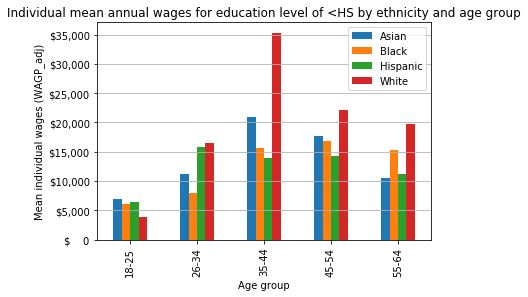

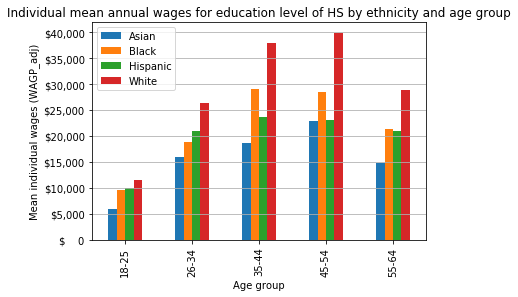

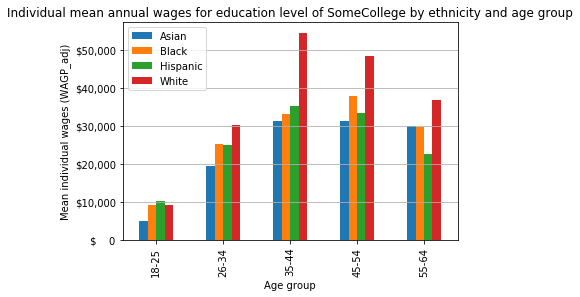

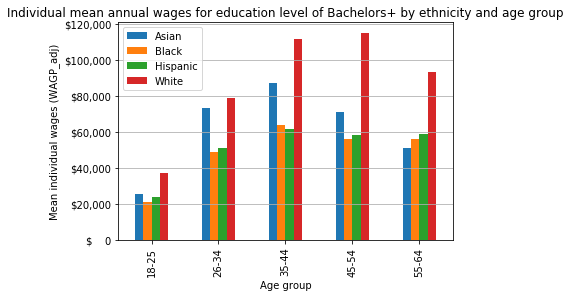

In [38]:
ethnicities = ['Asian', 'Black', 'Hispanic', 'White']
levels = ['<HS', 'HS', 'SomeCollege', 'Bachelors+']
age_groups = {'18-25':(18,25), '26-34':(26,34), '35-44':(35,44), '45-54':(45,54), '55-64':(55,64)}

for level, axis in zip(levels, range(len(levels))):
    
    # Create dataframe of mean weighted WAGP_adj for (levels) with (age groups) as columns and (ethnicities) as rows
    means = pd.DataFrame(index=list(age_groups.keys()), columns=ethnicities)

    for ages_key, ages in age_groups.items():
        for ethnicity in ethnicities:
            temp = cats_2016.copy()
            temp = temp.loc[(temp.Ethnicity == ethnicity) & (temp.EducAttain == level) & (temp.AGEP >= ages[0]) & (temp.AGEP <= ages[1])]
            #print('Number of ' + ethnicity + ' people with ' + level + ' aged between ' + str(ages[0]) + '-' + str(ages[1]) + ': ' + str(len(temp)))
            temp['Wgtd_WAGP'] = temp.WAGP_adj * temp.PWGTP
            count = temp.Wgtd_WAGP.sum()
            denom = temp.PWGTP.sum()
            means.loc[ages_key, ethnicity] = count/denom
    
    # Create a chart
    ax = means.plot(kind='bar')
    ax.set_xlabel('Age group')
    ax.set_ylabel('Mean individual wages (WAGP_adj)')
    ax.set_title('Individual mean annual wages for education level of ' + level + ' by ethnicity and age group')
    ax.set_yticklabels(['${:5,.0f}'.format(x) for x in ax.get_yticks()])
    ax.grid(which='major', axis='y')

***
Looking at population and ethnicity by boro, the Bronx is roughly 57% Hispanic, while Staten Island is over 60% white.
Black people are most populous in the Bronx and Brooklyn, while the strongest Asian population is in Queens.
***

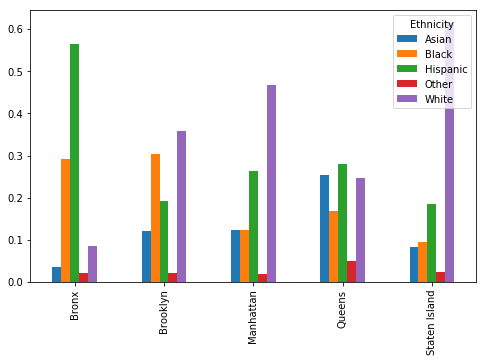

In [39]:
agg = pd.DataFrame()
for b in ['Bronx', 'Brooklyn', 'Manhattan', 'Queens', 'Staten Island']:
    tester = df_for_stat_chart(cats_2016.loc[cats_2016.Boro == b], 'Ethnicity', 'PWGTP')
    agg[b] = tester.PWGTP
agg.index.name = 'Ethnicity'
ax = agg.T.plot(kind='bar', figsize=(8,5))

***
Ability to speak English correlates strongly with mean wages for those with some college or more.

At lower education levels, English-only speakers actually earn slightly less on average.

Sample sizes for each of these groups are at least 460 individuals.
***

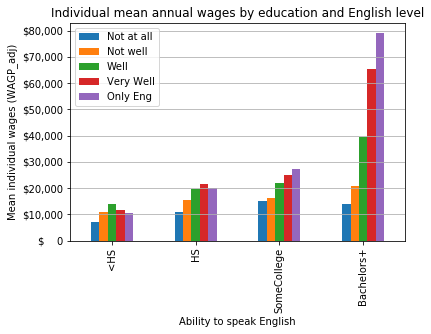

In [40]:
levels = ['<HS', 'HS', 'SomeCollege', 'Bachelors+']
skills = ['Not at all', 'Not well', 'Well', 'Very Well', 'Only Eng']

# Create dataframe of mean weighted WAGP_adj with (skills) as columns and (levels) as rows
means = pd.DataFrame(index=levels, columns=skills)

for level in levels:
    for skill in skills:
        temp = cats_2016.copy()
        temp = temp.loc[(temp.ENG == skill) & (temp.EducAttain == level) & (temp.AGEP >= 18)] 
        #print('Number of people with ' + level + ' with English skills of ' + skill + ': ' + str(len(temp)))
        temp['Wgtd_WAGP'] = temp.WAGP_adj * temp.PWGTP
        count = temp.Wgtd_WAGP.sum()
        denom = temp.PWGTP.sum()
        means.loc[level, skill] = count/denom
    
# Create a chart
ax = means.plot(kind='bar')
ax.set_xlabel('Ability to speak English')
ax.set_ylabel('Mean individual wages (WAGP_adj)')
ax.set_title('Individual mean annual wages by education and English level')
ax.set_yticklabels(['${:5,.0f}'.format(x) for x in ax.get_yticks()])
ax.grid(which='major', axis='y')

***
Over 28% of Asian New Yorkers speak English 'not at all' or 'not well.' Over 23% of Hispanics speak English 'not at all' or 'not well'.
***

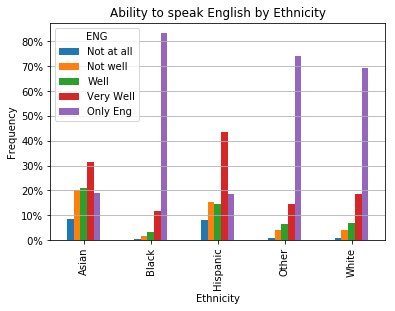

In [41]:
counts = cats_2016.loc[cats_2016.ENG != '<5'].groupby(['Ethnicity', 'ENG']).PWGTP.sum()
sums = cats_2016.loc[cats_2016.ENG != '<5'].groupby('Ethnicity').PWGTP.sum()
pcts = 100*counts/sums
pcts = pcts.unstack('ENG').iloc[:, [0,1,4,3,2]]

# Create a chart
ax = pcts.plot(kind='bar')
ax.set_xlabel('Ethnicity')
ax.set_ylabel('Frequency')
ax.set_title('Ability to speak English by Ethnicity')
ax.set_yticklabels(['{:2.0f}%'.format(x) for x in ax.get_yticks()])
ax.grid(which='major', axis='y')

***
Let's look now at family type.  Poverty rates by family type range from 12% for couples with no children, to over 30% for 
single mothers or unrelated families renting space in someone else's home.

We see below that those two family types ('Unrelated' and 'W+kid') also correspond to the lowest mean household gross incomes (PreTaxIncome_PU).

An interesting comparison below is among the relative mean household incomes of men and women, with and without children. 
Men without children have a mean household income that is roughly \\$6,000 higher than men with children. That gap in 
mean gross income is nearly \\$22,000 for women with children, versus women without children, suggesting that single
women with children lose much more income than single men with children.  (Again, disclaimers about confounding variables 
and correlation vs causation are in effect here.)

***

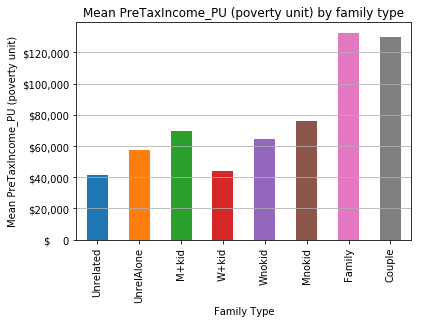

In [42]:
temp = pu_cats_2016.copy()
types = ['Unrelated', 'UnrelAlone', 'M+kid', 'W+kid', 'Wnokid', 'Mnokid', 'Family', 'Couple']
#types = ['Couple', 'Family', 'Mnokid', 'M+kid', 'UnrelAlone', 'Unrelated', 'W+kid', 'Wnokid']
means = pd.Series(index=types)

for type in types:
    counts = df_for_stat_chart(temp.loc[temp.FamType_PU == type], 'PreTaxIncome_PU', 'WGTP')
    counts['Weighted'] = counts.index * counts.WGTP
    means[type] = counts.sum().Weighted
   
ax = means.plot(kind='bar')
ax.set_title('Mean PreTaxIncome_PU (poverty unit) by family type')
ax.set_ylabel('Mean PreTaxIncome_PU (poverty unit)')
ax.set_xlabel('Family Type')
ax.set_yticklabels(['${:5,.0f}'.format(x) for x in ax.get_yticks()])
ax.grid(which='major', axis='y')

***
Among households in poverty, mean incomes are much lower, averaging out to \\$10,000-15,000 per year per person, or less. 
***

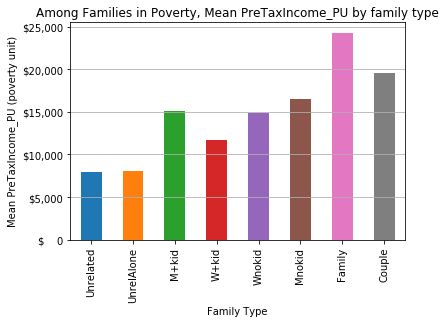

In [43]:
temp = pu_cats_2016.copy()
types = ['Unrelated', 'UnrelAlone', 'M+kid', 'W+kid', 'Wnokid', 'Mnokid', 'Family', 'Couple']
means = pd.Series(index=types)

for type in types:
    counts = df_for_stat_chart(temp.loc[(temp.FamType_PU == type) & (temp.NYCgov_Pov_Stat == 'Pov')], 'PreTaxIncome_PU', 'WGTP')
    counts['Weighted'] = counts.index * counts.WGTP
    means[type] = counts.sum().Weighted
    
ax = means.plot(kind='bar')
ax.set_title('Among Families in Poverty, Mean PreTaxIncome_PU by family type')
ax.set_ylabel('Mean PreTaxIncome_PU (poverty unit)')
ax.set_xlabel('Family Type')
ax.set_yticklabels(['${:5,.0f}'.format(x) for x in ax.get_yticks()])
ax.grid(which='major', axis='y')

***
Among households in poverty, most types of families receive enough public assistance such that their NYCgov_Income (income + assistance - costs) is actually greater than their gross household income (PreTaxIncome_PU).

The two types of households that on average do not, are couples without children and unrelated families/couples 
renting space in someone else's house.
***

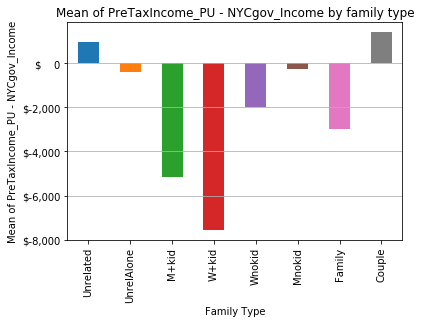

In [44]:
temp = pu_cats_2016.copy()
types = ['Unrelated', 'UnrelAlone', 'M+kid', 'W+kid', 'Wnokid', 'Mnokid', 'Family', 'Couple']
means = pd.Series(index=types)

for type in types:
    temp['Income_Diff'] = temp.PreTaxIncome_PU - temp.NYCgov_Income
    counts = df_for_stat_chart(temp.loc[(temp.FamType_PU == type) & (temp.NYCgov_Pov_Stat == 'Pov')], 'Income_Diff', 'WGTP')
    counts['Weighted'] = counts.index * counts.WGTP
    means[type] = counts.sum().Weighted
    
ax = means.plot(kind='bar')
ax.set_title('Mean of PreTaxIncome_PU - NYCgov_Income by family type')
ax.set_ylabel('Mean of PreTaxIncome_PU - NYCgov_Income')
ax.set_xlabel('Family Type')
ax.set_yticklabels(['${:5,.0f}'.format(x) for x in ax.get_yticks()])
ax.grid(which='major', axis='y')

***
Who are these unrelated people renting in someone else's house?  They tend to be young.  As we saw above, the low mean
income for this family type would indicate that renting in someone else's home is likely essentially forced by their
financial situation.
***

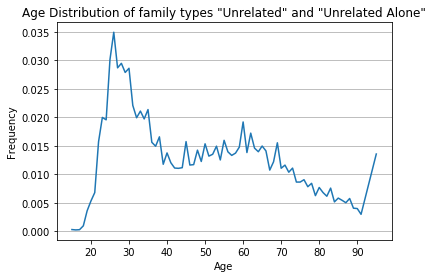

In [45]:
unrel = df_for_stat_chart(cats_2016.loc[(cats_2016.FamType_PU == 'Unrelated') | (cats_2016.FamType_PU == 'UnrelAlone')], 'AGEP', 'PWGTP')
ax = unrel.plot(legend=None)
ax.set_title('Age Distribution of family types "Unrelated" and "Unrelated Alone"')
ax.set_ylabel('Frequency')
ax.set_xlabel('Age')
#ax.set_yticklabels(['${:5,.0f}'.format(x) for x in ax.get_yticks()])
ax.grid(which='major', axis='y')

***
Let's look now at disability status.  As we see below, about 8% of the working-age NYC population is disabled, while 36%
of older New Yorkers are disabled.
***

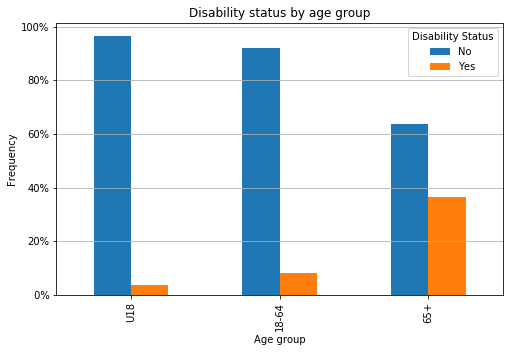

In [46]:
agg = pd.DataFrame()
for x in ['U18', '18-64', '65+']:
    tester = df_for_stat_chart(cats_2016.loc[cats_2016.AgeCateg == x], 'DIS', 'PWGTP')
    agg[x] = tester.PWGTP
agg.index.name = 'Disability Status'
ax = agg.T.plot(kind='bar', figsize=(8,5))
ax.set_title('Disability status by age group')
ax.set_ylabel('Frequency')
ax.set_xlabel('Age group')
ax.set_yticklabels(['{:2.0f}%'.format(100*x) for x in ax.get_yticks()])
ax.grid(which='major', axis='y')

***
Among working-age adults, the gap in mean wages between disabled and non-disabled New Yorkers is over \\$20,000. In
particular, the average wage for disabled adults is a paltry \\$14,761.
***

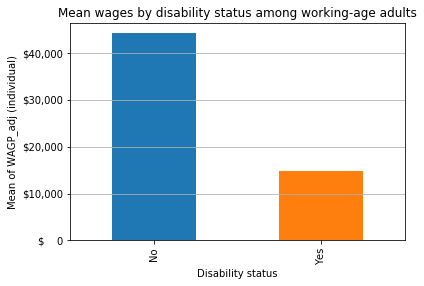

In [47]:
temp = cats_2016.copy()
statuses = ['No', 'Yes']
means = pd.Series(index=statuses)

for status in statuses:
    counts = df_for_stat_chart(temp.loc[(temp.DIS == status) & (temp.AGEP >= 18) & (temp.AGEP <= 65)], 'WAGP_adj', 'PWGTP')
    counts['Weighted'] = counts.index * counts.PWGTP
    means[status] = counts.sum().Weighted
    
ax = means.plot(kind='bar')
ax.set_title('Mean wages by disability status among working-age adults')
ax.set_ylabel('Mean of WAGP_adj (individual)')
ax.set_xlabel('Disability status')
ax.set_yticklabels(['${:5,.0f}'.format(x) for x in ax.get_yticks()])
ax.grid(which='major', axis='y')

***
Looking at all households with a disabled person and NYCgov_Income (this is net income taking into account any tax breaks 
and medical costs), the situation is slightly less dire - poverty units with a disabled member average about \\$45,000 
annually.
***

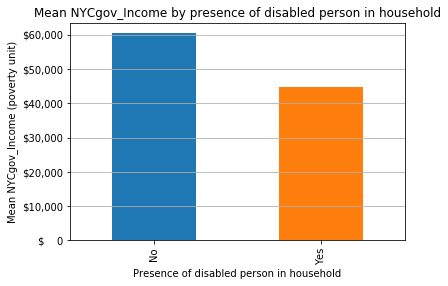

In [48]:
temp = all_2016.copy()
# Create column DIS_pu for presence of disabled person in poverty unit
temp.loc[temp.DIS == 2, 'DIS'] = 0
temp = temp.join(temp.groupby('SERIALNO')['DIS'].max(), on='SERIALNO', rsuffix='_pu')
# Focus on poverty units only and rename Povunit_Rel so it works with function df_for_stat_chart below
temp = temp.loc[temp.Povunit_Rel == 1]
temp.loc[temp.Povunit_Rel == 1, 'Povunit_Rel'] = 'Head'

statuses = [0.0, 1.0]
means = pd.Series(index=statuses)

for status in statuses:
    counts = df_for_stat_chart(temp.loc[(temp.DIS_pu == status)], 'NYCgov_Income', 'WGTP')
    counts['Weighted'] = counts.index * counts.WGTP
    means[status] = counts.sum().Weighted
    
means.index = ['No', 'Yes']
ax = means.plot(kind='bar')
ax.set_title('Mean NYCgov_Income by presence of disabled person in household')
ax.set_ylabel('Mean NYCgov_Income (poverty unit)')
ax.set_xlabel('Presence of disabled person in household')
ax.set_yticklabels(['${:5,.0f}'.format(x) for x in ax.get_yticks()])
ax.grid(which='major', axis='y')

***
Let's look again at the boroughs of New York.  The overall poverty rates: Bronx: 25%; Brooklyn: 21%, Manhattan: 14%,
Queens: 19%, Staten Island:17%.
***

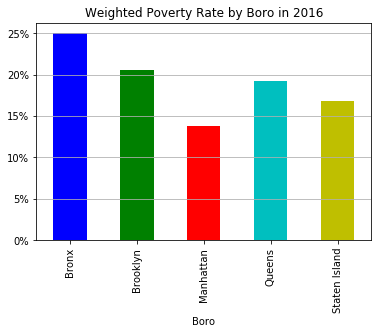

In [49]:
n = 1
pcts = df_for_pov_chart(cats_2016, 'Boro', 'PWGTP')

ax = pcts.plot.bar(title='Weighted Poverty Rate by Boro in 2016', legend=None, color='bgrcymk')
plt.gca().set_yticklabels(['{:.0f}%'.format(x) for x in plt.gca().get_yticks()])
ax.grid(which='major', axis='y')

***
We saw above that family type has a strong influence on poverty rates, with families and couples having lower poverty rates
and single parents and unrelated others having higher poverty rates.

Below we see that Manhattan bucks the trend, with nearly 60% of households being 'unrelated' despite the lowest poverty rate
in NYC. (Higher Manhattan incomes are part of that story as well.)

Less obvious, but also important: nearly 20% of households in the Bronx are single-parent households. 

Also notable, over 45% of Staten Island households are couples or families; along with Staten Island's high incomes, its
lower poverty rate is understandable.
***

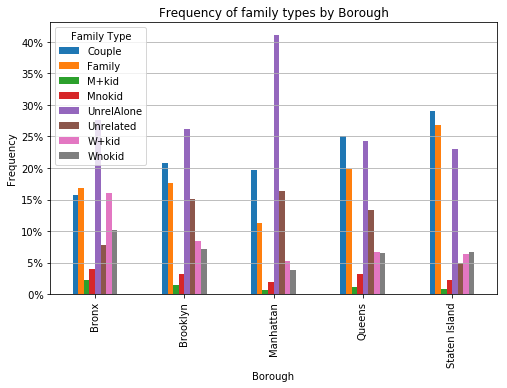

In [50]:
agg = pd.DataFrame()
for b in ['Bronx', 'Brooklyn', 'Manhattan', 'Queens', 'Staten Island']:
    tester = df_for_stat_chart(pu_cats_2016.loc[pu_cats_2016.Boro == b], 'FamType_PU', 'WGTP')
    agg[b] = tester.WGTP
agg.index.name = 'Family Type'
ax = agg.T.plot(kind='bar', figsize=(8,5))
plt.gca().set_yticklabels(['{:2.0f}%'.format(100*x) for x in plt.gca().get_yticks()])
ax.set_title('Frequency of family types by Borough')
ax.set_xlabel('Borough')
ax.set_ylabel('Frequency')
ax.grid(which='major', axis='y')

***
Although Manhattan has a high rate of 'unrelated' households, it also has the highest rate of college graduates, at 50%.

In the Bronx, Brooklyn, and Queens, over 30% of the population does not have a high school diploma (it's 40% in the Bronx).
***

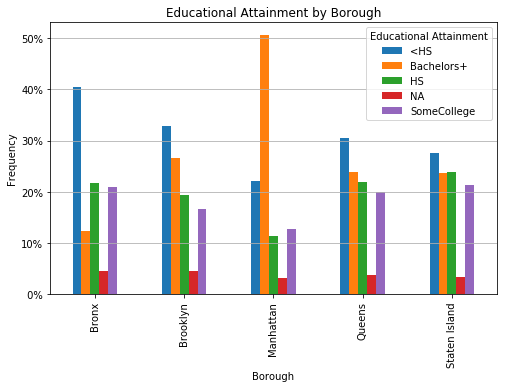

In [51]:
agg = pd.DataFrame()
for b in ['Bronx', 'Brooklyn', 'Manhattan', 'Queens', 'Staten Island']:
    tester = df_for_stat_chart(cats_2016.loc[cats_2016.Boro == b], 'EducAttain', 'PWGTP')
    agg[b] = tester.PWGTP
agg.index.name = 'Educational Attainment'
ax = agg.T.plot(kind='bar', figsize=(8,5))
plt.gca().set_yticklabels(['{:2.0f}%'.format(100*x) for x in plt.gca().get_yticks()])
ax.set_title('Educational Attainment by Borough')
ax.set_xlabel('Borough')
ax.set_ylabel('Frequency')
ax.grid(which='major', axis='y')

***
Staten Island has the highest percentage of households with over 3,500 work hours annually, as well as the highest 
percentage of households with no work hours annually.

40% of the households in the Bronx have less than 1,750 work hours annually (the equivalent of one part-time worker).
***

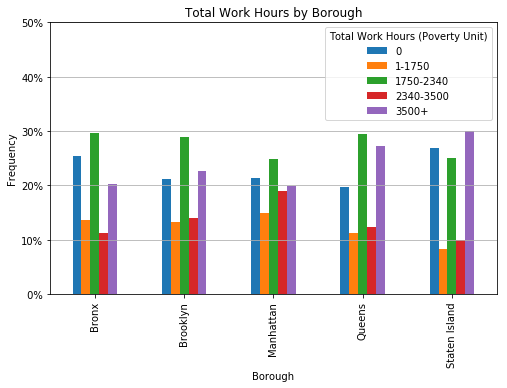

In [52]:
agg = pd.DataFrame()
for b in ['Bronx', 'Brooklyn', 'Manhattan', 'Queens', 'Staten Island']:
    tester = df_for_stat_chart(cats_2016.loc[cats_2016.Boro == b], 'TotalWorkHrs_PU', 'WGTP')
    agg[b] = tester.WGTP
new_ind = ['1750-2340', '2340-3500', '3500+', '1-1750', '0']
agg.set_axis(new_ind, axis=0)
agg.sort_index(inplace=True)
agg.index.name = 'Total Work Hours (Poverty Unit)'
ax = agg.T.plot(kind='bar', figsize=(8,5))
ax.set_ylim(0,0.5)
plt.gca().set_yticklabels(['{:2.0f}%'.format(100*x) for x in plt.gca().get_yticks()])
ax.set_title('Total Work Hours by Borough')
ax.set_xlabel('Borough')
ax.set_ylabel('Frequency')
ax.grid(which='major', axis='y')

***
Fully 20% of the population in the Bronx speaks English 'not at all' or 'not well', compared to less than 5% in Staten Island.
***

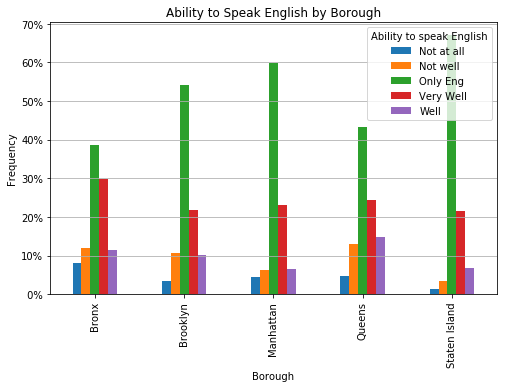

In [53]:
agg = pd.DataFrame()
for b in ['Bronx', 'Brooklyn', 'Manhattan', 'Queens', 'Staten Island']:
    tester = df_for_stat_chart(cats_2016.loc[(cats_2016.Boro == b) & (cats_2016.AGEP >= 18)], 'ENG', 'PWGTP')
    agg[b] = tester.PWGTP
agg.index.name = 'Ability to speak English'
ax = agg.T.plot(kind='bar', figsize=(8,5))
plt.gca().set_yticklabels(['{:2.0f}%'.format(100*x) for x in plt.gca().get_yticks()])
ax.set_title('Ability to Speak English by Borough')
ax.set_xlabel('Borough')
ax.set_ylabel('Frequency')
ax.grid(which='major', axis='y')

***
While naturalized citizens have a poverty rate (19%) that's close to that of natural-born citizens (17%), non-citizens have
a mean poverty rate of 26%.

Queens (21%) and the Bronx (19%) have the highest percentages of non-citizens, and Staten Island the lowest (8%).
***

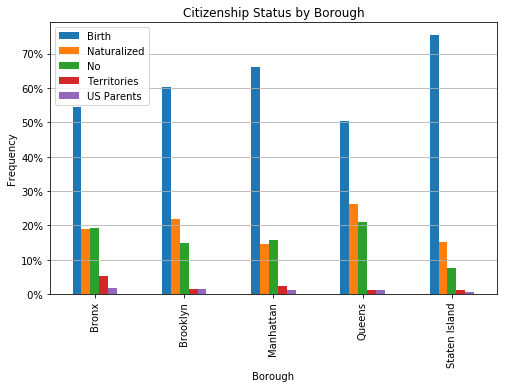

In [54]:
agg = pd.DataFrame()
for b in ['Bronx', 'Brooklyn', 'Manhattan', 'Queens', 'Staten Island']:
    tester = df_for_stat_chart(cats_2016.loc[cats_2016.Boro == b], 'CIT', 'PWGTP')
    agg[b] = tester.PWGTP
agg.index.name = 'Citizenship Status'
ax = agg.T.plot(kind='bar', figsize=(8,5))
ax.legend(loc='best')
plt.gca().set_yticklabels(['{:2.0f}%'.format(100*x) for x in plt.gca().get_yticks()])
ax.set_title('Citizenship Status by Borough')
ax.set_xlabel('Borough')
ax.set_ylabel('Frequency')
ax.grid(which='major', axis='y')

***
The poverty rate by the number of people mostly looks like you'd expect.  There are a few outliers at larger poverty-unit
sizes due to small sample sizes, but it generally increases with more people.  
***

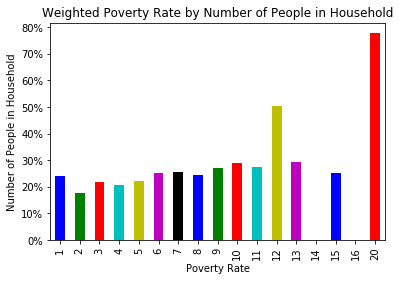

In [55]:
pcts = df_for_pov_chart(pu_cats_2016, 'NP', 'WGTP')
ax = pcts.plot(kind='bar', title = 'Weighted Poverty Rate by Number of People in Household', legend=None, color='bgrcymk')
ax.grid(which='major', axis='y')
plt.gca().set_yticklabels(['{:.0f}%'.format(x) for x in plt.gca().get_yticks()])
ax.set_xlabel('Poverty Rate')
ax.set_ylabel('Number of People in Household')
ax.grid(which='major', axis='y')

***
One thing in the chart above might be a little surprising: the poverty rate for a household of one person (24%) is higher than for two people (17.5%).   
And it's also higher than the poverty rate for 3-person households (22%).  Why?

Turns out that single-person households are older: the mean age of the head of a 1-person household is 55 years old,
compared to 50 years old for a 2-person household and 45 years old for a 3-person household. So your typical 1-person
household is about to retire, and lots of them already have.
***

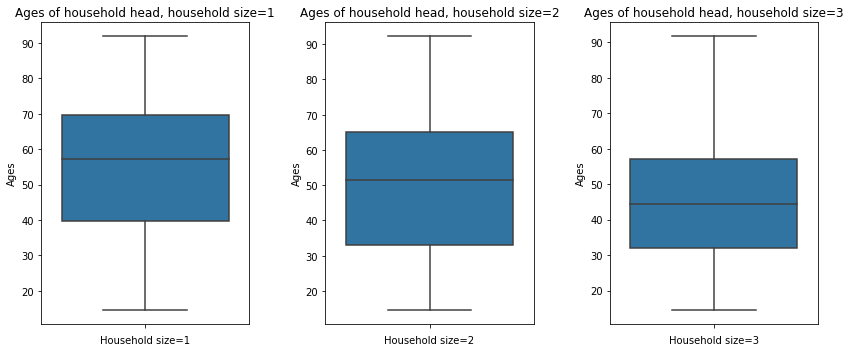

In [56]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12,5), sharex=True, sharey=True)

# shim to push the visuals to match weighted data
shim_factors = [55.441924936588464/57.27899138684309, 50.34332690982467/51.816464552238806, 45.23916544131444/46.82927308447937]

for axis in [1,2,3]:
    title = 'Ages of household head, household size=' + str(axis)
    count = pu_2016[(pu_2016.NP == axis)].AGEP * shim_factors[axis-1]
    plt.subplot(1, 3, axis)
    ax = sns.boxplot(count, orient='v')
    ax.set_xlabel('Household size=' + str(axis))
    ax.set_ylabel('Ages')
    ax.set_title(title)
    ax.set_yticklabels(['{:2.0f}'.format(x) for x in ax.get_yticks()])
plt.tight_layout()

***
Women have a poverty rate of 20.7%, while men have a poverty rate of 18.0%.  Why?

Overall, at every education level, and in every age group, men get paid more than women.  Often substantially more.
***

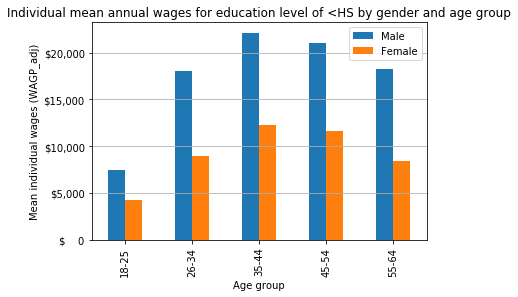

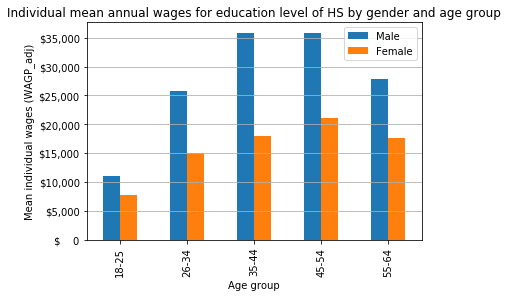

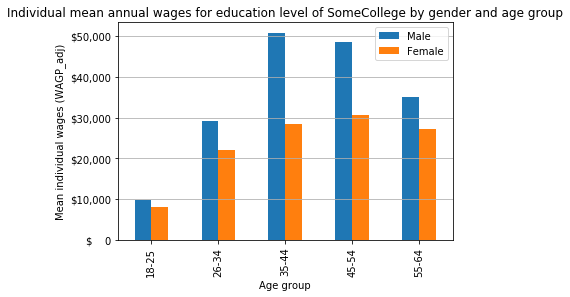

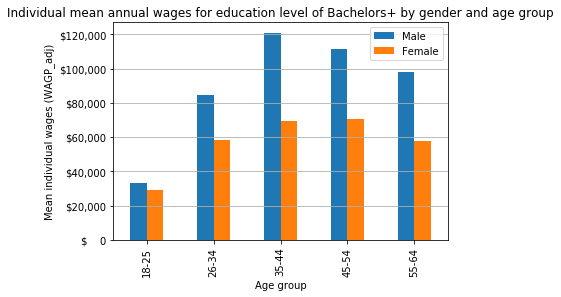

In [57]:
genders = ['Male', 'Female']
levels = ['<HS', 'HS', 'SomeCollege', 'Bachelors+']
age_groups = {'18-25':(18,25), '26-34':(26,34), '35-44':(35,44), '45-54':(45,54), '55-64':(55,64)}

for level, axis in zip(levels, range(len(levels))):
    
    # Create dataframe of mean weighted WAGP_adj for (levels) with (age groups) as columns and (ethnicities) as rows
    means = pd.DataFrame(index=list(age_groups.keys()), columns=genders)

    for ages_key, ages in age_groups.items():
        for gender in genders:
            temp = cats_2016.copy()
            temp = temp.loc[(temp.SEX == gender) & (temp.EducAttain == level) & (temp.AGEP >= ages[0]) & (temp.AGEP <= ages[1])]
            #print('Number of ' + gender + 's with ' + level + ' aged between ' + str(ages[0]) + '-' + str(ages[1]) + ': ' + str(len(temp)))
            temp['Wgtd_WAGP'] = temp.WAGP_adj * temp.PWGTP
            count = temp.Wgtd_WAGP.sum()
            denom = temp.PWGTP.sum()
            means.loc[ages_key, gender] = count/denom
    
    # Create a chart
    ax = means.plot(kind='bar')
    ax.set_xlabel('Age group')
    ax.set_ylabel('Mean individual wages (WAGP_adj)')
    ax.set_title('Individual mean annual wages for education level of ' + level + ' by gender and age group')
    ax.set_yticklabels(['${:5,.0f}'.format(x) for x in ax.get_yticks()])
    ax.grid(which='major', axis='y')

***
The data doesn't give us enough information to be able to dig into why, but we can at least do some significance testing.

The smallest difference above is among men and women aged 18-25 with some college.  We can see from the p-value below of zero to three digits that we can say with a high degree of confidence that the difference is real. (Sample sizes here are over 5,000 individuals in each group.)
***

In [58]:
one = cats_2016[(cats_2016.SEX == 'Male') & (cats_2016.EducAttain == 'SomeCollege')]
two = cats_2016[(cats_2016.SEX == 'Female') & (cats_2016.EducAttain == 'SomeCollege')]
comp = CompareMeans.from_data(one.WKHP, two.WKHP, weights1=one.PWGTP, weights2=two.PWGTP)
print('Comparing male to female aged 18-25 with some college' + ': ' + str(comp.summary()))

Comparing male to female aged 18-25 with some college:                           Test for equality of means                          
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
subset #1      5.6002      0.032    175.778      0.000       5.538       5.663


***
One question that arose from initial data exploration was why people who owned their home free & clear actually had a
higher poverty rate (14%) than people with a mortgage (11%).  

As we see below, the average person who who owns their 
home free and clear is 62 years old, while the average mortgage-holder is 52 years old. Thus the higher poverty rate 
among those who own their home outright.
***

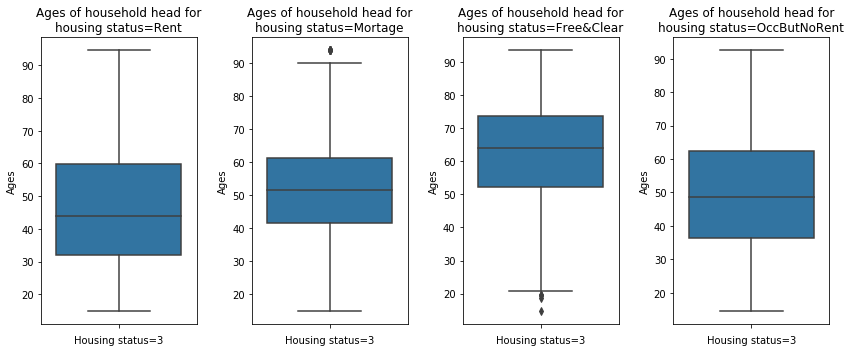

In [59]:
status = ['Rent', 'Mortage', 'Free&Clear', 'OccButNoRent']

# shim to push the visuals to match weighted data
shim_factors = [46.59734833844347/46.81741460911216, 51.77118164053281/52.39526926509967, 62.251087560108225/63.17148846960168, 50.817597551644994/52.18904593639576]

fig, axes = plt.subplots(nrows=1, ncols=len(status), figsize=(12,5), sharex=True, sharey=True)

for i in range(len(status)):
    title = 'Ages of household head for\nhousing status=' + str(status[i])
    count = pu_cats_2016[(pu_cats_2016.TEN == status[i])].AGEP * shim_factors[i]
    plt.subplot(1, len(status), i+1)
    ax = sns.boxplot(count, orient='v')
    ax.set_xlabel('Housing status=' + str(axis))
    ax.set_ylabel('Ages')
    ax.set_title(title)
    ax.set_yticklabels(['{:2.0f}'.format(x) for x in ax.get_yticks()])
plt.tight_layout()

***
Looking at those who are not in the labor force, most of those not working or looking for work are either at the young or
old end of the working-age spectrum.
***

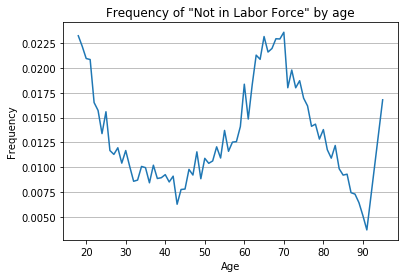

In [60]:
temp = cats_2016.copy()

all = df_for_stat_chart(cats_2016.loc[(cats_2016.ESR == 'NILF') & (temp.AGEP >= 18)], 'AGEP', 'PWGTP')

# Chart
ax = all.plot(legend=None)
ax.set_title('Frequency of "Not in Labor Force" by age')
ax.set_ylabel('Frequency')
ax.set_xlabel('Age')
ax.grid(which='major', axis='y')

***
'Not in the labor force' does not imply that the person is disabled, as the chart below (of those who are not disabled and not in the labor force) looks like the chart above. In fact, only 20% of working-aged New Yorkers who are not in the 
workforce are disabled.
***

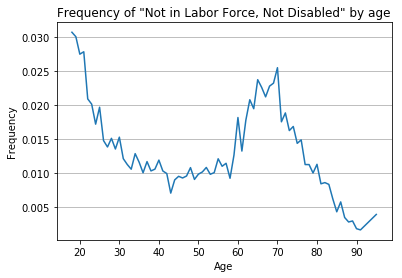

In [61]:
temp = cats_2016.copy()

all = df_for_stat_chart(cats_2016.loc[(cats_2016.ESR == 'NILF') & (temp.AGEP >= 18) & (temp.DIS == 'No')], 'AGEP', 'PWGTP')

# Chart
ax = all.plot(legend=None)
ax.set_title('Frequency of "Not in Labor Force, Not Disabled" by age')
ax.set_ylabel('Frequency')
ax.set_xlabel('Age')
ax.grid(which='major', axis='y')

***
In fact, the income distributions among households with and without an adult in the labor force are nearly 
indistinguishable at first glance, as shown below (with a focus on the IQR since outliers make the chart illegible). 
***

Mean NYCgov_Income among households with an adult not in the labor force: $54,231
Mean NYCgov_Income among households without an adult not in the labor force: $65,870


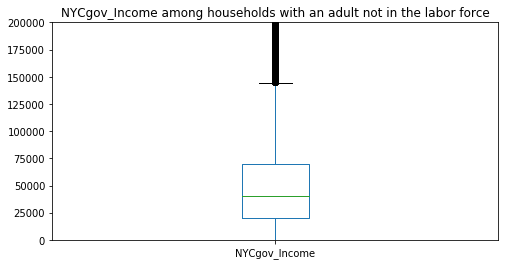

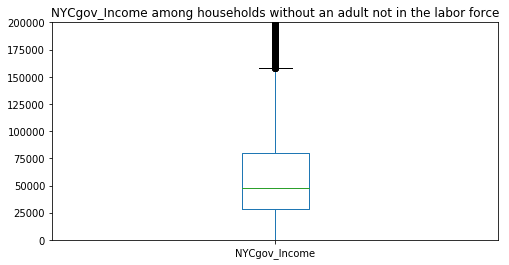

In [62]:
# Create column ESR_pu for presence of 'not in labor force' person in poverty unit
temp = all_2016.copy()
temp = temp.join(temp.groupby('SERIALNO')['ESR'].max(), on='SERIALNO', rsuffix='_pu')
temp.loc[temp.ESR_pu == 6, 'ESR_pu'] = 'NILF'
temp.loc[temp.ESR_pu != 'NILF', 'ESR_pu'] = 'No'
# Select only households
temp = temp.loc[temp.Povunit_Rel == 1]

nilf = temp.loc[(temp.ESR_pu == 'NILF') & (temp.AGEP >= 18) & (temp.AGEP < 65)].NYCgov_Income
not_nilf = temp.loc[(temp.ESR_pu != 'NILF') & (temp.AGEP >= 18) & (temp.AGEP < 65)].NYCgov_Income
    
print('Mean NYCgov_Income among households with an adult not in the labor force: ' + '${:6,.0f}'.format(nilf.mean()))
print('Mean NYCgov_Income among households without an adult not in the labor force: ' + '${:6,.0f}'.format(not_nilf.mean()))
    
nilf.plot(kind='box', title = 'NYCgov_Income among households with an adult not in the labor force', 
          ylim=(0,200000), figsize=(8,4))
plt.show()
not_nilf.plot(kind='box', title = 'NYCgov_Income among households without an adult not in the labor force', 
              ylim=(0,200000), figsize=(8,4))
plt.show()

***
In fact there are over 2,000 working-age households in NYC in poverty with at least one member not in the workforce. 
Only 25% of these not-in-the-labor-force workers are disabled. Their NYCgov_Income box plot is not so rosy.
***

Mean NYCgov_Income among households in poverty with an adult not in the labor force: $14,434


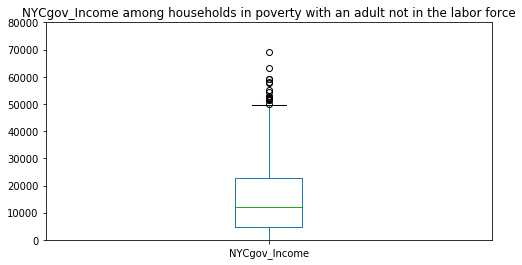

In [63]:
# Create column ESR_pu for presence of 'not in labor force' person in poverty unit
temp = all_2016.copy()
temp = temp[(temp.AGEP >= 18) & (temp.AGEP < 65)].join(temp.loc[(temp.AGEP >= 18) & (temp.AGEP < 65)].groupby('SERIALNO')['ESR'].max(), on='SERIALNO', rsuffix='_pu')
temp.loc[temp.ESR_pu == 6, 'ESR_pu'] = 'NILF'
temp.loc[temp.ESR_pu != 'NILF', 'ESR_pu'] = 'No'
# Select only households
temp = temp.loc[temp.Povunit_Rel == 1]

nilf_pv = temp.loc[(temp.ESR_pu == 'NILF') & (temp.AGEP >= 18) & (temp.AGEP < 65) & (temp.NYCgov_Pov_Stat == 1)].NYCgov_Income
    
print('Mean NYCgov_Income among households in poverty with an adult not in the labor force: ' + '${:6,.0f}'.format(nilf_pv.mean()))
    
nilf_pv.plot(kind='box', title = 'NYCgov_Income among households in poverty with an adult not in the labor force', 
          ylim=(0,80000), figsize=(8,4))
plt.show()

***
While the data don't tell us why individuals aren't in the workforce, the mean number of people in working-age households
with an adult not in the labor force is higher by 1.2 people than the mean in households without an adult not in the work
force. 
***

Mean number of people in working-age households with an adult not in the labor force: 3.7
Mean number of people in working-age households without an adult not in the labor force: 2.5


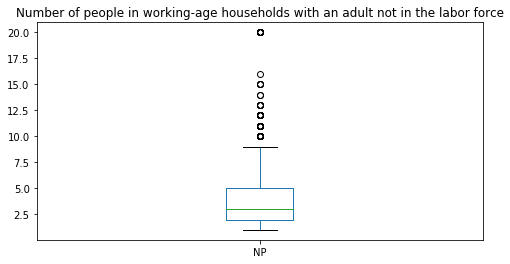

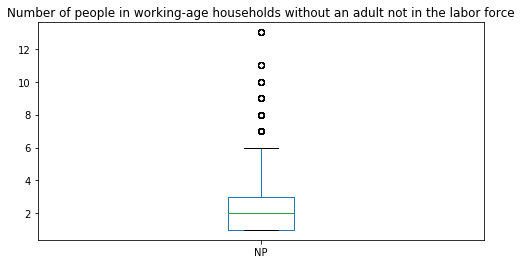

In [64]:
# Create column ESR_pu for presence of 'not in labor force' person in poverty unit
temp = all_2016.copy()
temp = temp[(temp.AGEP >= 18) & (temp.AGEP < 65)].join(temp.loc[(temp.AGEP >= 18) & (temp.AGEP < 65)].groupby('SERIALNO')['ESR'].max(), on='SERIALNO', rsuffix='_pu')
temp.loc[temp.ESR_pu == 6, 'ESR_pu'] = 'NILF'
temp.loc[temp.ESR_pu != 'NILF', 'ESR_pu'] = 'No'
# Select only households
temp = temp.loc[temp.Povunit_Rel == 1]

nilf = temp.loc[(temp.ESR_pu == 'NILF') & (temp.AGEP >= 18) & (temp.AGEP < 65)].NP
not_nilf = temp.loc[(temp.ESR_pu != 'NILF') & (temp.AGEP >= 18) & (temp.AGEP < 65)].NP

print('Mean number of people in working-age households with an adult not in the labor force: ' + '{:2.1f}'.format(nilf.mean()))
print('Mean number of people in working-age households without an adult not in the labor force: ' + '{:2.1f}'.format(not_nilf.mean()))
    
nilf.plot(kind='box', title = 'Number of people in working-age households with an adult not in the labor force', 
          figsize=(8,4))
plt.show()
not_nilf.plot(kind='box', title = 'Number of people in working-age households without an adult not in the labor force', 
              figsize=(8,4))
plt.show()